In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import openpyxl
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score,classification_report, precision_score, recall_score,f1_score,confusion_matrix,ConfusionMatrixDisplay, roc_curve,roc_auc_score, precision_recall_curve
from sklearn.model_selection import train_test_split,cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import  make_scorer
import pickle

In [2]:
os.chdir('H:\PRA')
pd.set_option('display.max_columns',None)

In [3]:
df = pd.read_excel('SampleDonorData2.xlsx',sheet_name = 'Project Data')

In [4]:
df.shape

(19971, 29)

In [5]:
df.columns = map(str.lower,df.columns)
df.describe()

,target_b,target_d6,target_d12,target_d18,target_d24,control_number,months_since_origin,number_of_resp,donor_age,in_house,cluster_code,income_group,published_phone,wealth_rating,median_home_value,median_household_income,pct_owner_occupied,pep_star,recent_star_status,recent_card_response_prop,months_since_last_prom_resp,last_gift_amt,number_prom_12,months_since_last_gift,months_since_first_gift
count,19971.000000,19971.000000,19971.000000,19971.000000,19971.000000,19971.000000,19971.000000,19971.000000,14997.000000,19971.000000,19504.000000,15448.000000,19971.000000,10879.000000,19971.000000,19971.000000,19971.000000,19971.000000,19971.000000,19971.000000,19748.000000,18116.000000,19971.000000,19971.000000,19971.000000
mean,0.050173,14.671921,41.101756,66.622684,81.984172,96559.465926,81.717741,12.893796,59.072014,0.073106,27.865053,3.902253,0.497672,4.996415,1080.004456,341.941415,69.688649,0.504481,0.221020,0.230875,21.513723,77.996195,12.893796,18.200040,69.573131
std,0.218307,104.439410,267.862505,421.172053,524.494029,55833.214544,72.635986,4.620044,16.582433,0.260317,14.452831,1.866635,0.500007,2.816912,963.201512,164.485223,21.707324,0.499992,0.414945,0.186339,16.253099,1231.091711,4.620044,4.028913,37.655067
min,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-12.000000,-1300.000000,2.000000,4.000000,15.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,48285.000000,29.000000,11.000000,47.000000,0.000000,15.000000,2.000000,0.000000,3.000000,517.000000,232.000000,60.000000,0.000000,0.000000,0.100000,16.000000,0.000000,11.000000,16.000000,33.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,96951.000000,65.000000,12.000000,60.000000,0.000000,28.000000,4.000000,0.000000,5.000000,745.000000,311.000000,76.000000,1.000000,0.000000,0.200000,18.000000,20.000000,12.000000,18.000000,65.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,145492.000000,113.000000,13.000000,73.000000,0.000000,40.000000,5.000000,1.000000,7.000000,1227.000000,417.500000,85.000000,1.000000,0.000000,0.333000,21.000000,69.735000,13.000000,20.000000,105.000000
max,1.000000,4079.800000,9200.000000,11400.000000,15973.870000,191779.000000,1139.000000,64.000000,87.000000,1.000000,53.000000,7.000000,1.000000,9.000000,6000.000000,1500.000000,99.000000,1.000000,1.000000,1.000000,376.000000,159362.800000,64.000000,27.000000,260.000000


Min value for months_since_last_prom_resp and last_gift_amt is **negative**. This looks off

In [6]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19971 entries, 0 to 19970
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   target_b                     19971 non-null  int64  
 1   target_d6                    19971 non-null  float64
 2   target_d12                   19971 non-null  float64
 3   target_d18                   19971 non-null  float64
 4   target_d24                   19971 non-null  float64
 5   control_number               19971 non-null  int64  
 6   months_since_origin          19971 non-null  int64  
 7   number_of_resp               19971 non-null  int64  
 8   donor_age                    14997 non-null  float64
 9   in_house                     19971 non-null  int64  
 10  urbanicity                   19971 non-null  object 
 11  cluster_code                 19504 non-null  float64
 12  home_owner                   19971 non-null  object 
 13  donor_gender    

In [7]:
print('% of donors: ', df.target_b.sum() / df.shape[0]*100, '%') 
df.target_b.value_counts()

% of donors:  5.01727504882079 %


target_b
0    18969
1     1002
Name: count, dtype: int64

**Unbalanced data**
Use **Stratified** test train split

Check if there are any repeated rows:

In [8]:
print('nunique: ',df.control_number.nunique())
print('shape: ',df.shape[0])


nunique:  19372
shape:  19971


From the above 2 cells, there are repeated control_numbers

**Removing entire duplicated rows:**

In [9]:
df.drop_duplicates(keep='first').shape

(19933, 29)

In [10]:
df = df.drop_duplicates(keep='first')
df.shape

(19933, 29)

Removed 38 duplicated rows

In [11]:
print('df shape: ' ,df.shape)
print('df cn nunique: ' ,df.control_number.nunique())

df shape:  (19933, 29)
df cn nunique:  19372


In [12]:
print('duplicated rows: ',19933-19372)

duplicated rows:  561


**Check and treat the multiple donors / duplicate control number (ID)**

In [13]:
df_duplicated = df[df.duplicated(['control_number'],keep = False)]
df_duplicated.shape


(1068, 29)

In [14]:
df_duplicated.control_number.nunique()


507

There 507 unique donors who are repeated in the data (we may have data issues or they were targeted twice). Randomly check first few duplicate donors



In [15]:
df_duplicated.sort_values(by=['control_number'], inplace = True)

C:\Users\GC\AppData\Local\Temp\ipykernel_50992\178605981.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_duplicated.sort_values(by=['control_number'], inplace = True)


In [16]:
df_duplicated.head(10)

,target_b,target_d6,target_d12,target_d18,target_d24,control_number,months_since_origin,number_of_resp,donor_age,in_house,urbanicity,cluster_code,home_owner,donor_gender,income_group,published_phone,wealth_rating,median_home_value,median_household_income,pct_owner_occupied,pep_star,recent_star_status,recency_freq_status,recent_card_response_prop,months_since_last_prom_resp,last_gift_amt,number_prom_12,months_since_last_gift,months_since_first_gift
10436,0,0.0,0.0,0.0,0.0,1064,242,30,69.0,0,S,14.0,U,M,NaN,0,8.0,1437,583,97,1,1,S3,0.182,14.0,0.0,30,7,121
10437,0,0.0,0.0,0.0,0.0,1064,159,30,69.0,0,S,14.0,U,M,NaN,0,8.0,1437,583,97,1,1,S3,0.182,14.0,0.0,30,7,121
18454,0,0.0,0.0,0.0,0.0,1480,4,20,NaN,0,U,9.0,U,F,1.0,0,3.0,1507,421,84,1,0,A1,0.100,4.0,72.0,20,7,57
18455,0,0.0,0.0,0.0,0.0,1480,18,20,NaN,0,U,9.0,U,F,1.0,0,3.0,1507,421,84,1,0,A1,0.100,15.0,72.0,20,7,57
18456,0,0.0,0.0,0.0,0.0,1480,43,20,NaN,0,U,9.0,U,F,1.0,0,3.0,1507,421,84,1,0,A1,0.100,15.0,72.0,20,7,57
11531,0,0.0,0.0,0.0,0.0,1617,70,28,75.0,0,S,13.0,H,F,4.0,0,NaN,5970,1386,94,1,0,A3,0.500,11.0,100.0,28,6,45
11532,0,0.0,0.0,0.0,0.0,1617,44,28,75.0,0,S,13.0,H,F,4.0,0,NaN,5970,1386,94,1,0,A3,0.500,11.0,100.0,28,6,45
18467,0,0.0,0.0,0.0,0.0,1970,279,15,NaN,0,T,40.0,U,F,6.0,0,NaN,680,408,90,1,0,A2,0.364,17.0,NaN,15,17,102
18466,0,0.0,0.0,0.0,0.0,1970,28,15,NaN,0,T,40.0,U,F,6.0,0,NaN,680,408,90,1,0,A2,0.364,17.0,NaN,15,17,102
5082,0,0.0,0.0,0.0,0.0,2501,36,23,63.0,0,C,25.0,H,F,5.0,0,NaN,508,239,30,0,0,F1,1.000,15.0,250.0,23,15,20


In [17]:
df_duplicated.tail(10)

,target_b,target_d6,target_d12,target_d18,target_d24,control_number,months_since_origin,number_of_resp,donor_age,in_house,urbanicity,cluster_code,home_owner,donor_gender,income_group,published_phone,wealth_rating,median_home_value,median_household_income,pct_owner_occupied,pep_star,recent_star_status,recency_freq_status,recent_card_response_prop,months_since_last_prom_resp,last_gift_amt,number_prom_12,months_since_last_gift,months_since_first_gift
14523,0,0.0,0.0,0.0,0.0,190001,55,4,NaN,0,S,16.0,U,F,NaN,0,NaN,687,302,77,0,0,E1,1.000,18.0,60.00,4,18,18
14522,0,0.0,0.0,0.0,0.0,190001,325,4,NaN,0,S,16.0,U,F,NaN,0,NaN,687,302,77,0,0,E1,1.000,18.0,60.00,4,18,18
15501,0,0.0,0.0,0.0,0.0,190727,1,9,80.0,1,?,NaN,U,F,3.0,0,0.0,655,236,78,1,0,A1,0.222,1.0,0.00,9,26,98
15502,0,0.0,0.0,0.0,0.0,190727,242,9,80.0,1,?,NaN,U,F,3.0,0,0.0,655,236,78,1,0,A1,0.222,30.0,0.00,9,26,98
10802,0,0.0,0.0,0.0,0.0,191260,137,13,72.0,1,?,NaN,U,F,3.0,0,2.0,526,155,48,1,1,S3,0.091,12.0,0.00,13,18,120
10801,0,0.0,0.0,0.0,0.0,191260,137,13,72.0,1,?,NaN,U,F,3.0,0,2.0,526,155,48,1,1,S3,0.091,14.0,0.00,13,18,120
6208,0,0.0,0.0,0.0,0.0,191530,20,13,63.0,0,?,NaN,U,F,4.0,1,NaN,910,400,74,1,0,A3,0.000,15.0,0.00,13,15,65
6207,0,0.0,0.0,0.0,0.0,191530,118,13,63.0,0,?,NaN,U,F,4.0,1,NaN,910,400,74,1,0,A3,0.000,15.0,0.00,13,15,65
11522,0,0.0,0.0,0.0,0.0,191643,2,13,74.0,1,C,27.0,H,M,2.0,0,8.0,985,466,87,1,1,S2,0.200,2.0,306.25,13,18,121
11521,0,0.0,0.0,0.0,0.0,191643,91,13,74.0,1,C,27.0,H,M,2.0,0,8.0,985,466,87,1,1,S2,0.200,18.0,306.25,13,18,121


From above two dataframes, we can say that we have duplicated records due to two attributes (differing values for the same control_number): 

months_since_origin

months_since_last_prom_resp


CHecking if only these two are the only differing col:


In [18]:
df_duplicated.drop(['months_since_origin','months_since_last_prom_resp'],axis=1).drop_duplicates(keep='first').shape

(507, 27)

As the above dataframes shape matches with the number of duplicated rows, we can say for sure that following attributes have caused multiple rows.

months_since_origin

months_since_last_prom_resp

Based on what those attributes mean in the meta file, I am assuming that the data was not updated appropriately when new values were received. 

**Keeping only the latest values and removing the dups** (as we dont have datetime when the record was created, assuming here that the smallest value of months_since_last_prom_resp is more important)

prioritizing "months_since_last_prom_resp" over "months_since_origin" as it adds more value to the objective

In [19]:
df_clean = df.copy()

In [20]:
df_clean.shape

(19933, 29)

In [21]:
df_clean.sort_values(['months_since_last_prom_resp','months_since_origin'],inplace=True)

In [22]:
df_clean = df_clean.drop_duplicates(subset='control_number',keep='first')

In [23]:
print('df_clean shape: ' ,df_clean.shape)
print('df_clean cn nunique: ' ,df_clean.control_number.nunique())

df_clean shape:  (19372, 29)
df_clean cn nunique:  19372


**The above Dataframe does not have any duplicate control_number**

Creating a multi entry columns for both months_since_origin and months_since_last_prom_resp which will tell the model the number of unique values each control_number had 

In [24]:
df_duplicated_join = df_duplicated.groupby('control_number').agg({'months_since_last_prom_resp':'nunique','months_since_origin':'nunique' }).reset_index()

In [25]:
df_duplicated_join.rename(columns={'months_since_last_prom_resp': 'multi_months_since_last_prom_resp', 'months_since_origin':'multi_months_since_origin'}, inplace=True)

In [26]:
df_duplicated_join.shape


(507, 3)

In [27]:
df_duplicated_join.multi_months_since_last_prom_resp.value_counts()

multi_months_since_last_prom_resp
1    288
2    207
3      6
0      5
5      1
Name: count, dtype: int64

In [28]:
df_duplicated_join.multi_months_since_origin.value_counts()

multi_months_since_origin
2    410
1     49
3     47
5      1
Name: count, dtype: int64

In [29]:
df = df_clean.merge(df_duplicated_join, on ='control_number', how= 'left')

In [30]:
df.shape


(19372, 31)

Fixing negative values (likely incorrect entries)

In [31]:
df[df.last_gift_amt<0]

,target_b,target_d6,target_d12,target_d18,target_d24,control_number,months_since_origin,number_of_resp,donor_age,in_house,urbanicity,cluster_code,home_owner,donor_gender,income_group,published_phone,wealth_rating,median_home_value,median_household_income,pct_owner_occupied,pep_star,recent_star_status,recency_freq_status,recent_card_response_prop,months_since_last_prom_resp,last_gift_amt,number_prom_12,months_since_last_gift,months_since_first_gift,multi_months_since_last_prom_resp,multi_months_since_origin
7799,0,0.0,0.0,0.0,0.0,173892,137,13,NaN,0,S,12.0,H,F,5.0,1,7.0,1381,409,72,1,0,A1,0.273,17.0,-216.0,13,17,118,NaN,NaN
12392,0,0.0,0.0,0.0,0.0,71604,20,11,51.0,0,C,28.0,H,F,3.0,1,6.0,588,332,87,1,1,S3,0.364,20.0,-1300.0,11,22,124,NaN,NaN
14834,0,0.0,0.0,0.0,0.0,23178,65,16,76.0,0,C,30.0,H,F,3.0,0,0.0,485,239,62,1,1,S2,0.100,22.0,-30.0,16,18,56,NaN,NaN
16986,0,0.0,0.0,0.0,0.0,67723,29,9,57.0,0,U,10.0,H,M,4.0,0,NaN,120,52,49,0,0,A1,0.000,26.0,-50.0,9,26,31,NaN,NaN
17585,0,0.0,0.0,0.0,0.0,179359,137,9,17.0,0,T,35.0,U,F,2.0,1,9.0,2321,631,90,1,0,A1,0.000,26.0,-100.0,9,26,130,NaN,NaN


In [32]:
df[df.months_since_last_prom_resp<0]

,target_b,target_d6,target_d12,target_d18,target_d24,control_number,months_since_origin,number_of_resp,donor_age,in_house,urbanicity,cluster_code,home_owner,donor_gender,income_group,published_phone,wealth_rating,median_home_value,median_household_income,pct_owner_occupied,pep_star,recent_star_status,recency_freq_status,recent_card_response_prop,months_since_last_prom_resp,last_gift_amt,number_prom_12,months_since_last_gift,months_since_first_gift,multi_months_since_last_prom_resp,multi_months_since_origin
0,0,0.0,0.0,0.0,0.0,134703,53,12,51.0,0,T,40.0,U,F,3.0,1,8.0,854,408,89,0,0,A1,0.111,-12.0,74.95,12,17,53,NaN,NaN
1,0,0.0,0.0,0.0,0.0,58351,89,14,69.0,0,R,51.0,U,M,5.0,1,NaN,269,224,81,1,0,A4,0.375,-11.0,0.00,14,18,78,NaN,NaN
2,0,0.0,0.0,0.0,0.0,104133,137,12,59.0,0,R,49.0,U,F,2.0,1,3.0,645,288,90,1,0,A1,0.000,-11.0,0.00,12,20,116,NaN,NaN
3,0,0.0,0.0,0.0,0.0,83486,41,12,55.0,0,U,9.0,H,F,1.0,1,NaN,0,181,0,0,0,A4,0.200,-10.0,105.95,12,18,41,NaN,NaN
4,0,0.0,0.0,0.0,0.0,1909,125,18,76.0,0,R,47.0,U,M,1.0,1,0.0,557,186,76,1,1,S4,0.364,-10.0,27.00,18,16,122,NaN,NaN
5,0,0.0,0.0,0.0,0.0,66731,65,9,87.0,0,C,27.0,U,F,2.0,1,6.0,754,341,86,1,0,A2,0.222,-9.0,0.00,9,20,64,NaN,NaN
6,0,0.0,0.0,0.0,0.0,52224,77,14,45.0,0,T,41.0,H,M,7.0,0,1.0,381,164,73,0,0,A1,0.222,-9.0,88.05,14,18,69,NaN,NaN
7,0,0.0,0.0,0.0,0.0,96008,125,11,NaN,0,T,41.0,H,F,1.0,0,1.0,300,87,37,1,1,S3,0.500,-9.0,0.00,11,16,118,NaN,NaN


In [33]:
df.loc[df.last_gift_amt<0,'last_gift_amt'] = -(df.last_gift_amt)
df.loc[df.months_since_last_prom_resp<0,'last_gift_amt'] = -(df.months_since_last_prom_resp)

**Null treatment**

multi_months_since_last_prom_resp and multi_months_since_origin tells if there were multiple rows in the dataset for the same controlnumber

In [34]:
df.multi_months_since_last_prom_resp.fillna(value=-1000,inplace=True)
df.multi_months_since_origin.fillna(value=-1000,inplace=True)

In [35]:
null_count = pd.DataFrame(df.isnull().sum(),index= None).reset_index()
null_count.columns = ['column','sum_nulls']
null_count['percent_null'] = null_count['sum_nulls'] / df.shape[0]*100
null_count = null_count[null_count.sum_nulls > 0 ]
null_count

,column,sum_nulls,percent_null
8,donor_age,4795,24.752220
11,cluster_code,454,2.343589
14,income_group,4392,22.671898
16,wealth_rating,8810,45.478009
24,months_since_last_prom_resp,217,1.120173
25,last_gift_amt,1783,9.204006



**Action plan (Nulls > 10%):** Cannot impute due to high % of Nulls



**donor_age** : for missing values, use -1000 to indicate to the model that the age is missing. Assumption here is that age could be an important value and dont want to drop the attribute completely

**income_group** : the value of income_group increases based on median_household_income. This is evidence that its continuous value. For missing using -1000 to indicate missing values 

**wealth_rating** : drop this variable. Reason - 45% null and is highly correlated with median_household_income and median_home_value. This will likely add no additional value and is likely calculated using those variables 





**Nulls <10%:**



**cluster_code** : This is a categorical variable and needs more information for its interpretation. as it has 53 values, the missing values will be bucketed into a new group and the rest of the values will be divided into 6 additional segments (0 to 10, 11 to 20 and so on.)

**months_since_last_prom_resp** : using median imputation as its skewed data 

**last_gift_amt** : using median imputation as its skewed data 





check income_group

In [36]:
df.groupby('income_group').agg({'median_household_income':'mean'})

,median_household_income
income_group,
1.0,256.658068
2.0,272.926123
3.0,302.453796
4.0,336.380443
5.0,365.401715
6.0,451.032684
7.0,475.973197


Check wealth_rating

In [37]:
df.groupby('wealth_rating').agg({'median_household_income':'mean'})

,median_household_income
wealth_rating,
0.0,205.547085
1.0,227.217799
2.0,245.198152
3.0,272.717973
4.0,291.745694
5.0,314.809833
6.0,346.116383
7.0,375.374479
8.0,426.679487


In [38]:
df.groupby('wealth_rating').agg({'median_home_value':'mean'})

,median_home_value
wealth_rating,
0.0,643.565022
1.0,638.533958
2.0,662.995893
3.0,805.323136
4.0,906.614995
5.0,951.128015
6.0,1037.810206
7.0,1147.039199
8.0,1372.106571


Check 'months_since_last_prom_resp'

<Axes: >

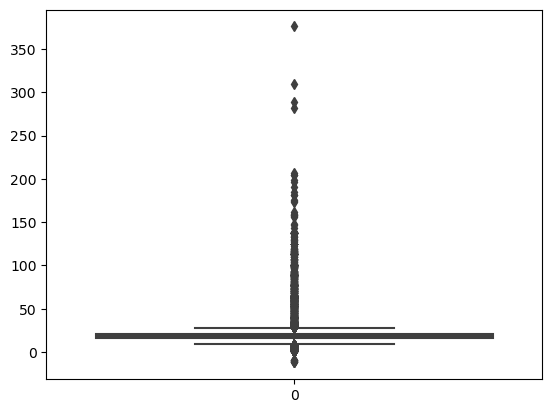

In [39]:
sns.boxplot(df.months_since_last_prom_resp)

C:\Users\GC\AppData\Local\Temp\ipykernel_45672\2468894076.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['months_since_last_prom_resp'])
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context(

<Axes: xlabel='months_since_last_prom_resp', ylabel='Density'>

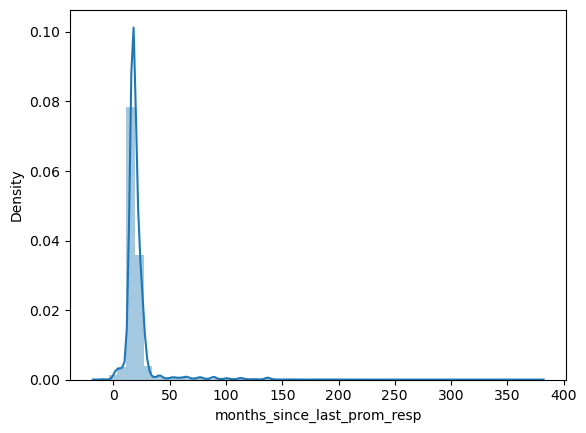

In [44]:
sns.distplot(df['months_since_last_prom_resp'])

In [40]:
print('months_since_last_prom_resp median: ',df.months_since_last_prom_resp.median())
print('months_since_last_prom_resp mean: ',df.months_since_last_prom_resp.mean())


months_since_last_prom_resp median:  18.0
months_since_last_prom_resp mean:  21.23288958496476


Check **last_gift_amt**

C:\Users\GC\AppData\Local\Temp\ipykernel_50992\608230972.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['last_gift_amt'])
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_a

<Axes: xlabel='last_gift_amt', ylabel='Density'>

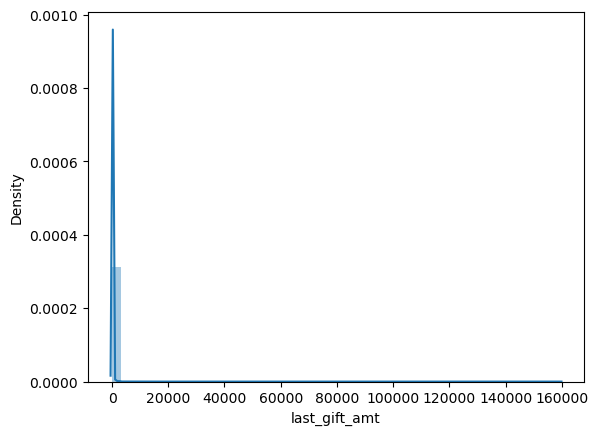

In [41]:
sns.distplot(df['last_gift_amt'])

In [42]:
print('last_gift_amt median: ',df.last_gift_amt.median())
print('last_gift_amt mean: ',df.last_gift_amt.mean())


last_gift_amt median:  20.0
last_gift_amt mean:  78.60377565523908


**Executing the Plan of Action:**

In [43]:
df1 = df.copy()

In [44]:
df1.loc[df1.donor_age<16, 'donor_age'] = -100
print('new category for age less than 16: ' , df1[df1.donor_age == -100].shape[0])
print('null count of donor_age: ',df1['donor_age'].isnull().sum())
df1['donor_age'].fillna(value = -1000,inplace=True)
print('null count of donor_age: ',df1['donor_age'].isnull().sum())


new category for age less than 16:  94
null count of donor_age:  4795
null count of donor_age:  0


In [45]:
print('null count of income_group: ',df1['income_group'].isnull().sum())
df1['income_group'].fillna(value = -1000,inplace=True)
print('null count of income_group: ',df1['income_group'].isnull().sum())

null count of income_group:  4392
null count of income_group:  0


In [46]:
df1.loc[(df1.cluster_code>=0) & (df1.cluster_code<=10),'cluster_code_new']= 'cluster_code_0to10'
df1.loc[(df1.cluster_code>10) & (df1.cluster_code<=20),'cluster_code_new']= 'cluster_code_11to20'
df1.loc[(df1.cluster_code>20) & (df1.cluster_code<=30),'cluster_code_new']= 'cluster_code_21to30'
df1.loc[(df1.cluster_code>30) & (df1.cluster_code<=40),'cluster_code_new']= 'cluster_code_31to40'
df1.loc[(df1.cluster_code>40) & (df1.cluster_code<=50),'cluster_code_new']= 'cluster_code_41to50'
df1.loc[(df1.cluster_code>50) ,'cluster_code_new']= 'cluster_code_51+'
df1.loc[(df1.cluster_code_new.isnull()) | (df1.cluster_code_new == 'nan'),'cluster_code_new'] = 'cluster_code_missing'

C:\Users\GC\AppData\Local\Temp\ipykernel_50992\1299526713.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'cluster_code_0to10' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df1.loc[(df1.cluster_code>=0) & (df1.cluster_code<=10),'cluster_code_new']= 'cluster_code_0to10'


In [47]:
df1.cluster_code_new.value_counts()

cluster_code_new
cluster_code_11to20     4138
cluster_code_31to40     4023
cluster_code_21to30     3865
cluster_code_41to50     3613
cluster_code_0to10      2456
cluster_code_51+         823
cluster_code_missing     454
Name: count, dtype: int64

**Exploring Categorical variables**

In [48]:
df1.describe(include='object')

,urbanicity,home_owner,donor_gender,recency_freq_status,cluster_code_new
count,19372,19372,19372,19372,19372
unique,6,2,4,23,7
top,S,H,F,A1,cluster_code_11to20
freq,4491,10606,10401,6801,4138


Attributes: urbanicity, home_owner, donor_gender can be directly **onehotencoded** as they have lower cardinality and would not increase the attributes drastically
Also, **they dont have any null values**

In [49]:
df1.recency_freq_status.value_counts()

recency_freq_status
A1    6801
A2    2304
A3    1614
F1    1452
S2    1413
S4    1376
S3    1356
A4    1199
N1     437
N2     367
N3     299
E1     265
N4      89
L1      87
S1      76
E4      69
F2      53
E2      50
E3      43
F4      10
F3       6
L2       4
L4       2
Name: count, dtype: int64

Reducing cardinality for **"recency_freq_status"**:

In [50]:
df1['recency_freq_status_cat'] = df1.recency_freq_status.str[0]

In [51]:
df1['recency_freq_status_cat'].value_counts()

recency_freq_status_cat
A    11918
S     4221
F     1521
N     1192
E      427
L       93
Name: count, dtype: int64

Reduced the cardinality from 23 to 6 for the "recency_freq_status"

Applying Onehotencoding using **Pandas Dummies** for the 4 attributes: urbanicity, home_owner, donor_gender,recency_freq_status_cat,cluster_code_new

In [52]:
cat_columns = ['urbanicity','home_owner','recency_freq_status_cat','donor_gender','cluster_code_new']
df_categoried = pd.get_dummies(df1,prefix_sep='_', columns = cat_columns)

In [53]:
drop_columns = ['recency_freq_status','wealth_rating','cluster_code']

df_categoried.drop(drop_columns,inplace=True,axis=1)

In [54]:
df_categoried.shape

(19372, 50)

In [55]:
df_categoried.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19372 entries, 0 to 19371
Data columns (total 50 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   target_b                               19372 non-null  int64  
 1   target_d6                              19372 non-null  float64
 2   target_d12                             19372 non-null  float64
 3   target_d18                             19372 non-null  float64
 4   target_d24                             19372 non-null  float64
 5   control_number                         19372 non-null  int64  
 6   months_since_origin                    19372 non-null  int64  
 7   number_of_resp                         19372 non-null  int64  
 8   donor_age                              19372 non-null  float64
 9   in_house                               19372 non-null  int64  
 10  income_group                           19372 non-null  float64
 11  pu

**Columns to Impute** : months_since_last_prom_resp, last_gift_amt

In [56]:
df_categoried['months_since_last_prom_resp'].fillna(value=df_categoried['months_since_last_prom_resp'].median(),inplace=True)

In [57]:
df_categoried['last_gift_amt'].fillna(value=df_categoried['last_gift_amt'].median(),inplace=True)

In [58]:
print('% of donors: ', df_categoried.target_b.sum() / df_categoried.shape[0]*100, '%') 
df_categoried.target_b.value_counts()

% of donors:  5.00206483584555 %


target_b
0    18403
1      969
Name: count, dtype: int64

**Stratified K folds** as the distribution is skewed

In [59]:
df_categoried

,target_b,target_d6,target_d12,target_d18,target_d24,control_number,months_since_origin,number_of_resp,donor_age,in_house,income_group,published_phone,median_home_value,median_household_income,pct_owner_occupied,pep_star,recent_star_status,recent_card_response_prop,months_since_last_prom_resp,last_gift_amt,number_prom_12,months_since_last_gift,months_since_first_gift,multi_months_since_last_prom_resp,multi_months_since_origin,urbanicity_?,urbanicity_C,urbanicity_R,urbanicity_S,urbanicity_T,urbanicity_U,home_owner_H,home_owner_U,recency_freq_status_cat_A,recency_freq_status_cat_E,recency_freq_status_cat_F,recency_freq_status_cat_L,recency_freq_status_cat_N,recency_freq_status_cat_S,donor_gender_A,donor_gender_F,donor_gender_M,donor_gender_U,cluster_code_new_cluster_code_0to10,cluster_code_new_cluster_code_11to20,cluster_code_new_cluster_code_21to30,cluster_code_new_cluster_code_31to40,cluster_code_new_cluster_code_41to50,cluster_code_new_cluster_code_51+,cluster_code_new_cluster_code_missing
0,0,0.00,0.00,0.00,0.0,134703,53,12,51.0,0,3.0,1,854,408,89,0,0,0.111,-12.0,12.0,12,17,53,-1000.0,-1000.0,False,False,False,False,True,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False
1,0,0.00,0.00,0.00,0.0,58351,89,14,69.0,0,5.0,1,269,224,81,1,0,0.375,-11.0,11.0,14,18,78,-1000.0,-1000.0,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
2,0,0.00,0.00,0.00,0.0,104133,137,12,59.0,0,2.0,1,645,288,90,1,0,0.000,-11.0,11.0,12,20,116,-1000.0,-1000.0,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False
3,0,0.00,0.00,0.00,0.0,83486,41,12,55.0,0,1.0,1,0,181,0,0,0,0.200,-10.0,10.0,12,18,41,-1000.0,-1000.0,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False
4,0,0.00,0.00,0.00,0.0,1909,125,18,76.0,0,1.0,1,557,186,76,1,1,0.364,-10.0,10.0,18,16,122,-1000.0,-1000.0,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19367,0,0.00,0.00,0.00,0.0,83966,307,10,51.0,0,5.0,1,890,454,92,0,0,0.000,18.0,0.0,10,20,20,-1000.0,-1000.0,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False
19368,0,0.00,0.00,0.00,0.0,8358,315,7,-1000.0,0,-1000.0,0,963,412,78,0,0,0.000,18.0,0.0,7,27,111,-1000.0,-1000.0,False,False,False,False,True,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False
19369,0,0.00,0.00,0.00,0.0,121581,431,13,48.0,0,-1000.0,1,1026,452,37,1,1,0.000,18.0,0.0,13,23,62,-1000.0,-1000.0,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False
19370,0,0.00,0.00,0.00,0.0,147386,515,13,52.0,0,5.0,0,4457,496,74,1,0,0.000,18.0,0.0,13,18,128,-1000.0,-1000.0,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False


In [60]:
df_dollar_var = df_categoried[['control_number','target_d6','target_d12','target_d18','target_d24']]

drop_dollar = ['target_d6','target_d12','target_d18','target_d24']

In [61]:
df_final = df_categoried.drop(drop_dollar, axis=1)

In [62]:
df_final.shape

(19372, 46)

In [68]:
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
target_b,19372.0,0.050021,0.217993,0.0,0.0,0.0,0.000,1.0
control_number,19372.0,96546.225377,55830.643871,5.0,48289.0,96937.0,145429.500,191779.0
months_since_origin,19372.0,79.468769,68.527992,1.0,29.0,65.0,113.000,1139.0
number_of_resp,19372.0,12.901869,4.642072,2.0,11.0,12.0,13.000,64.0
donor_age,19372.0,-203.705400,457.063053,-1000.0,-100.0,51.0,69.000,87.0
in_house,19372.0,0.073198,0.260469,0.0,0.0,0.0,0.000,1.0
income_group,19372.0,-223.697347,420.359478,-1000.0,1.0,3.0,5.000,7.0
published_phone,19372.0,0.497729,0.500008,0.0,0.0,0.0,1.000,1.0
median_home_value,19372.0,1079.871929,960.753448,0.0,518.0,747.0,1227.000,6000.0
median_household_income,19372.0,341.970215,164.207807,0.0,232.0,311.0,417.000,1500.0


In [69]:
#selecting them based on their max-min values/binary/categorical values
col_to_standardize = ['months_since_origin',
'number_of_resp',
'donor_age',
'income_group',
'published_phone',
'median_home_value',
'median_household_income',
'pct_owner_occupied',
'months_since_last_prom_resp',
'last_gift_amt',
'number_prom_12',
'months_since_last_gift',
'months_since_first_gift',
'multi_months_since_last_prom_resp',
'multi_months_since_origin'
]


<Axes: >

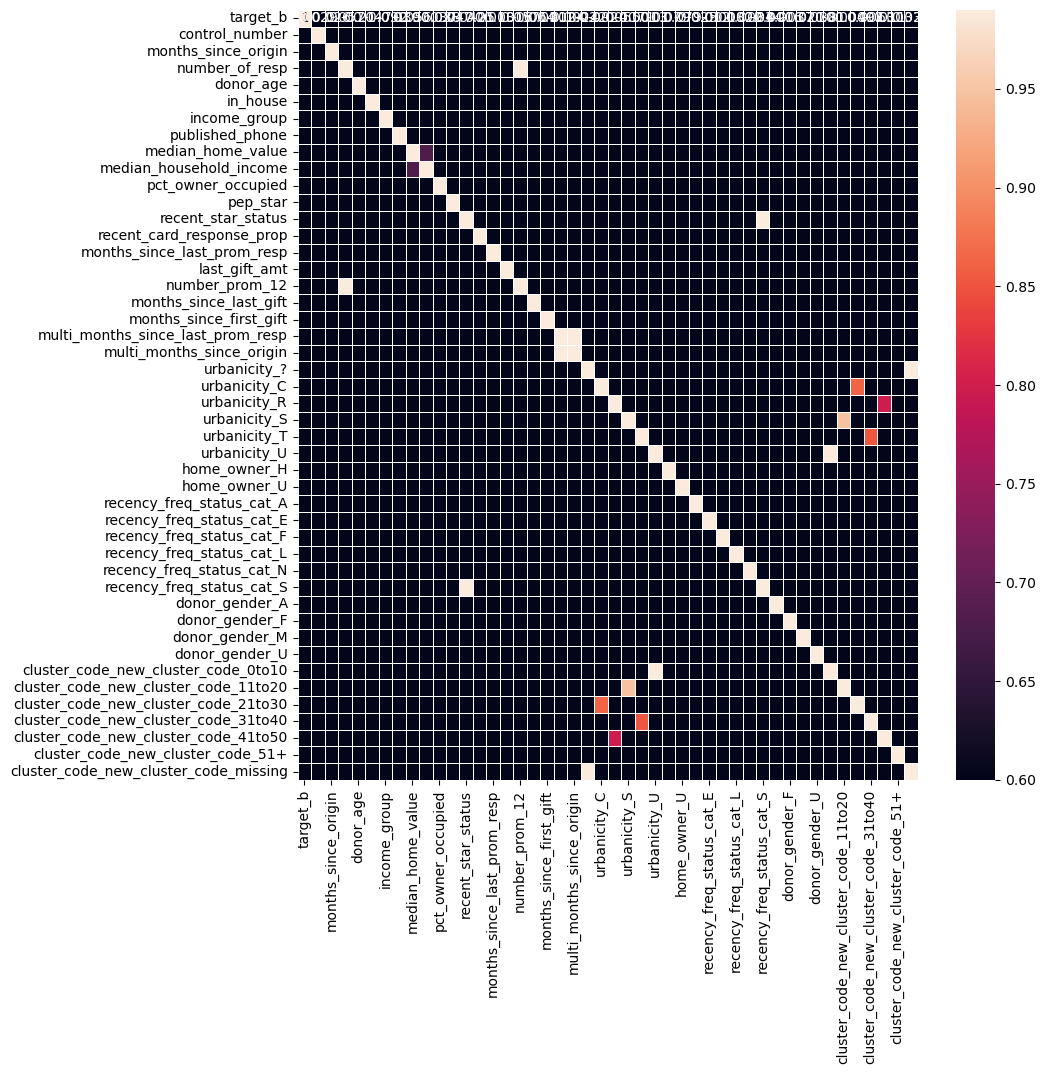

In [87]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_final.corr(),vmin=0.6,vmax=0.99,annot=True,fmt='.2g',linewidths=.5,ax=ax)




From the above, we can see there are some correlations

In [81]:
c = df_final.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")

In [83]:
corr = pd.DataFrame(so.reset_index())
corr.columns =['column1','column2','corr_value']

In [105]:
corr_investigate = corr[(corr.corr_value>0.8) & ~(corr.column1 == corr.column2)]

In [107]:
corr_investigate

,column1,column2,corr_value
2050,urbanicity_T,cluster_code_new_cluster_code_31to40,0.851383
2051,cluster_code_new_cluster_code_31to40,urbanicity_T,0.851383
2052,urbanicity_C,cluster_code_new_cluster_code_21to30,0.862895
2053,cluster_code_new_cluster_code_21to30,urbanicity_C,0.862895
2054,donor_gender_M,donor_gender_F,0.898604
2055,donor_gender_F,donor_gender_M,0.898604
2056,urbanicity_S,cluster_code_new_cluster_code_11to20,0.948709
2057,cluster_code_new_cluster_code_11to20,urbanicity_S,0.948709
2058,recent_star_status,recency_freq_status_cat_S,0.989812
2059,recency_freq_status_cat_S,recent_star_status,0.989812


In [109]:
corr_investigate.shape

(20, 3)

**From above, we have 10 variables correlated with each other. As Decision Trees handle multicolinearity better, using XGboost and not logistic Regression:**

In [234]:
X_train, X_test, y_train, y_test = train_test_split(df_final.iloc[:,1:], df_final.iloc[:,0],stratify=df_final.iloc[:,0], test_size=0.2, random_state=0)

C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [235]:
print('X_train: ',X_train.shape)
print('y_train: ',y_train.sum())
print('Ratio train: ',y_train.sum()/X_train.shape[0]*100,'%')
print('X_test: ',X_test.shape)
print('y_test: ',y_test.sum())
print('Ratio test: ',y_test.sum()/X_test.shape[0]*100,'%')

X_train:  (15497, 45)
y_train:  775
Ratio train:  5.000967929276634 %
X_test:  (3875, 45)
y_test:  194
Ratio test:  5.006451612903226 %


Standardizing for Faster convergence:

In [238]:
X_train

,control_number,months_since_origin,number_of_resp,donor_age,in_house,income_group,published_phone,median_home_value,median_household_income,pct_owner_occupied,pep_star,recent_star_status,recent_card_response_prop,months_since_last_prom_resp,last_gift_amt,number_prom_12,months_since_last_gift,months_since_first_gift,multi_months_since_last_prom_resp,multi_months_since_origin,urbanicity_?,urbanicity_C,urbanicity_R,urbanicity_S,urbanicity_T,urbanicity_U,home_owner_H,home_owner_U,recency_freq_status_cat_A,recency_freq_status_cat_E,recency_freq_status_cat_F,recency_freq_status_cat_L,recency_freq_status_cat_N,recency_freq_status_cat_S,donor_gender_A,donor_gender_F,donor_gender_M,donor_gender_U,cluster_code_new_cluster_code_0to10,cluster_code_new_cluster_code_11to20,cluster_code_new_cluster_code_21to30,cluster_code_new_cluster_code_31to40,cluster_code_new_cluster_code_41to50,cluster_code_new_cluster_code_51+,cluster_code_new_cluster_code_missing
9784,3026,0.308431,4.129283,0.501200,1,0.541244,0.999419,-0.165480,-0.734954,0.659141,1,0,0.091,-0.214988,-0.035061,4.129283,-3.015207,0.629619,-0.162146,-0.162146,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
945,93161,-0.955446,0.020735,-1.745853,0,-1.848325,-1.000581,-1.120526,0.164641,-1.629295,1,1,0.364,-0.483432,-0.013637,0.020735,0.443447,1.057180,-0.162146,-0.162146,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False
13797,75654,-0.287189,0.236974,-1.745853,0,0.534104,0.999419,-0.941974,-0.741032,0.521835,1,0,0.273,-0.013654,0.018915,0.236974,0.690494,0.469283,-0.162146,-0.162146,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False
11393,76051,-0.388881,0.020735,0.564713,0,-1.848325,-1.000581,-0.708403,-0.570838,0.430298,1,0,0.000,-0.147876,-0.044652,0.020735,0.196400,-0.466008,-0.162146,-0.162146,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
7423,152995,0.657086,-0.195504,0.595375,0,0.538864,0.999419,0.722089,0.626595,0.659141,1,1,0.182,-0.282099,-0.003796,-0.195504,-0.297693,1.404574,-0.162146,-0.162146,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17782,99308,0.308431,-0.844222,0.516531,0,0.543624,0.999419,-0.385556,-0.242608,-0.302002,0,0,0.000,0.389012,0.002185,-0.844222,2.172774,0.629619,-0.162146,-0.162146,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
12639,105210,-0.563208,-0.411744,0.601945,0,0.543624,0.999419,-0.225690,0.195032,-0.027390,0,0,0.250,-0.080765,-0.022721,-0.411744,0.443447,-0.759957,-0.162146,-0.162146,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
2959,112211,-0.911864,0.236974,0.590995,0,0.543624,-1.000581,-0.536079,-0.753189,-0.210465,0,0,0.500,-0.349210,-0.056787,0.236974,-0.544740,-1.294409,-0.162146,-0.162146,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True
8654,32661,-0.563208,-0.195504,0.604135,0,0.534104,0.999419,-0.576565,-0.327705,-0.164696,0,0,0.250,-0.214988,-0.034077,-0.195504,-0.050646,-0.947015,-0.162146,-0.162146,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False


In [237]:
sc = StandardScaler()
X_train[col_to_standardize] = sc.fit_transform(X_train[col_to_standardize])
X_test[col_to_standardize] = sc.transform(X_test[col_to_standardize])

C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Sparse

In [239]:
X_train

,control_number,months_since_origin,number_of_resp,donor_age,in_house,income_group,published_phone,median_home_value,median_household_income,pct_owner_occupied,pep_star,recent_star_status,recent_card_response_prop,months_since_last_prom_resp,last_gift_amt,number_prom_12,months_since_last_gift,months_since_first_gift,multi_months_since_last_prom_resp,multi_months_since_origin,urbanicity_?,urbanicity_C,urbanicity_R,urbanicity_S,urbanicity_T,urbanicity_U,home_owner_H,home_owner_U,recency_freq_status_cat_A,recency_freq_status_cat_E,recency_freq_status_cat_F,recency_freq_status_cat_L,recency_freq_status_cat_N,recency_freq_status_cat_S,donor_gender_A,donor_gender_F,donor_gender_M,donor_gender_U,cluster_code_new_cluster_code_0to10,cluster_code_new_cluster_code_11to20,cluster_code_new_cluster_code_21to30,cluster_code_new_cluster_code_31to40,cluster_code_new_cluster_code_41to50,cluster_code_new_cluster_code_51+,cluster_code_new_cluster_code_missing
9784,3026,0.308431,4.129283,0.501200,1,0.541244,0.999419,-0.165480,-0.734954,0.659141,1,0,0.091,-0.214988,-0.035061,4.129283,-3.015207,0.629619,-0.162146,-0.162146,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
945,93161,-0.955446,0.020735,-1.745853,0,-1.848325,-1.000581,-1.120526,0.164641,-1.629295,1,1,0.364,-0.483432,-0.013637,0.020735,0.443447,1.057180,-0.162146,-0.162146,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False
13797,75654,-0.287189,0.236974,-1.745853,0,0.534104,0.999419,-0.941974,-0.741032,0.521835,1,0,0.273,-0.013654,0.018915,0.236974,0.690494,0.469283,-0.162146,-0.162146,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False
11393,76051,-0.388881,0.020735,0.564713,0,-1.848325,-1.000581,-0.708403,-0.570838,0.430298,1,0,0.000,-0.147876,-0.044652,0.020735,0.196400,-0.466008,-0.162146,-0.162146,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
7423,152995,0.657086,-0.195504,0.595375,0,0.538864,0.999419,0.722089,0.626595,0.659141,1,1,0.182,-0.282099,-0.003796,-0.195504,-0.297693,1.404574,-0.162146,-0.162146,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17782,99308,0.308431,-0.844222,0.516531,0,0.543624,0.999419,-0.385556,-0.242608,-0.302002,0,0,0.000,0.389012,0.002185,-0.844222,2.172774,0.629619,-0.162146,-0.162146,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
12639,105210,-0.563208,-0.411744,0.601945,0,0.543624,0.999419,-0.225690,0.195032,-0.027390,0,0,0.250,-0.080765,-0.022721,-0.411744,0.443447,-0.759957,-0.162146,-0.162146,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
2959,112211,-0.911864,0.236974,0.590995,0,0.543624,-1.000581,-0.536079,-0.753189,-0.210465,0,0,0.500,-0.349210,-0.056787,0.236974,-0.544740,-1.294409,-0.162146,-0.162146,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True
8654,32661,-0.563208,-0.195504,0.604135,0,0.534104,0.999419,-0.576565,-0.327705,-0.164696,0,0,0.250,-0.214988,-0.034077,-0.195504,-0.050646,-0.947015,-0.162146,-0.162146,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False


## First approach Use XGboost

Non parameteric and XGBoost is not affected as much as Random forest is with class representation 

In [684]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=0
)

To counter class imbalance, using  **scale_pos_weight**

The scale_pos_weight value is used to scale the gradient for the positive class.

In [ ]:
parameters = {
#     'max_depth': range (2, 10, 1),
     'max_depth':  [3,4,5],
    'n_estimators': [50,100,150],
    'learning_rate': [0.1, 0.01, 0.05],
    'scale_pos_weight' : [5,10, 15,20]

}

In [395]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

use **recall** or **area under the precision-recall** as we care more about positive than negative class or **F1 Score** (The data is heavily imbalanced). 

area under the precision-recall curve can be estimated by the average_precision

In [396]:
# scorer = make_scorer(f1_score, pos_label=1)

In [416]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'f1',
    n_jobs = 10,
    cv = kfold,
    verbose=True
)

removing control number for the fit

In [417]:
grid_search.fit(X_train.iloc[:,1:], y_train)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_typ...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=10,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [4, 5, 6, 7],
                         'n_estimators': [50, 100, 150, 200],
                         'scale_pos_weight': [5, 10, 15, 20]},
             scoring='average_precision', verbose=True)

In [418]:
grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)

In [ ]:
print(grid_search.cv_results_)
print('\n Best estimator:')
print(grid_search.best_estimator_)

print('\n Best score:')
print(grid_search.best_score_)
print('\n Best parameters:')
print(grid_search.best_params_)
results = pd.DataFrame(grid_search.cv_results_)
results.to_csv('xgb-grid-search-results-03.csv', index=False)



In [614]:
y_pred_prob = grid_search.best_estimator_.predict_proba(X_test.iloc[:,1:])
y_pred = grid_search.best_estimator_.predict(X_test.iloc[:,1:])

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


In [421]:
y_pred

array([1, 0, 0, ..., 0, 1, 1])

In [422]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[2794  887]
 [  14  180]]


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `

0.767483870967742

In [674]:
180/1067
3x improvement

0.16869728209934395

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


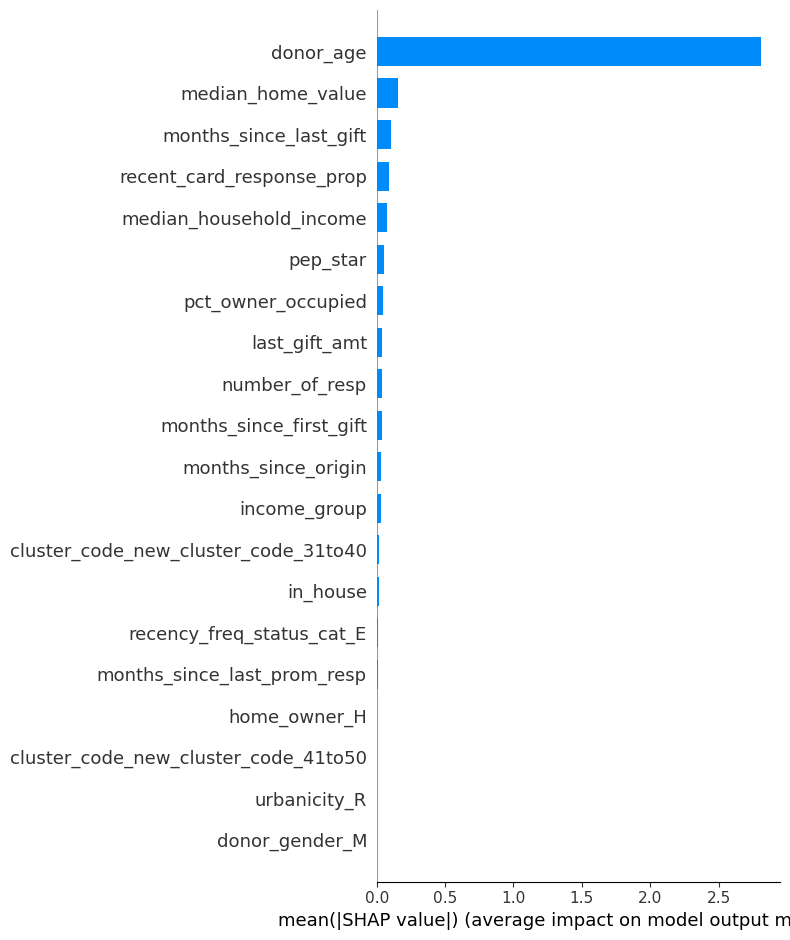

In [423]:
import shap
model_xg = grid_search.best_estimator_
explainer_xg = shap.TreeExplainer(model_xg)
shap_values_xg = explainer_xg.shap_values(X_train.iloc[:,1:])
shap.summary_plot(shap_values_xg, X_train.iloc[:,1:], plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


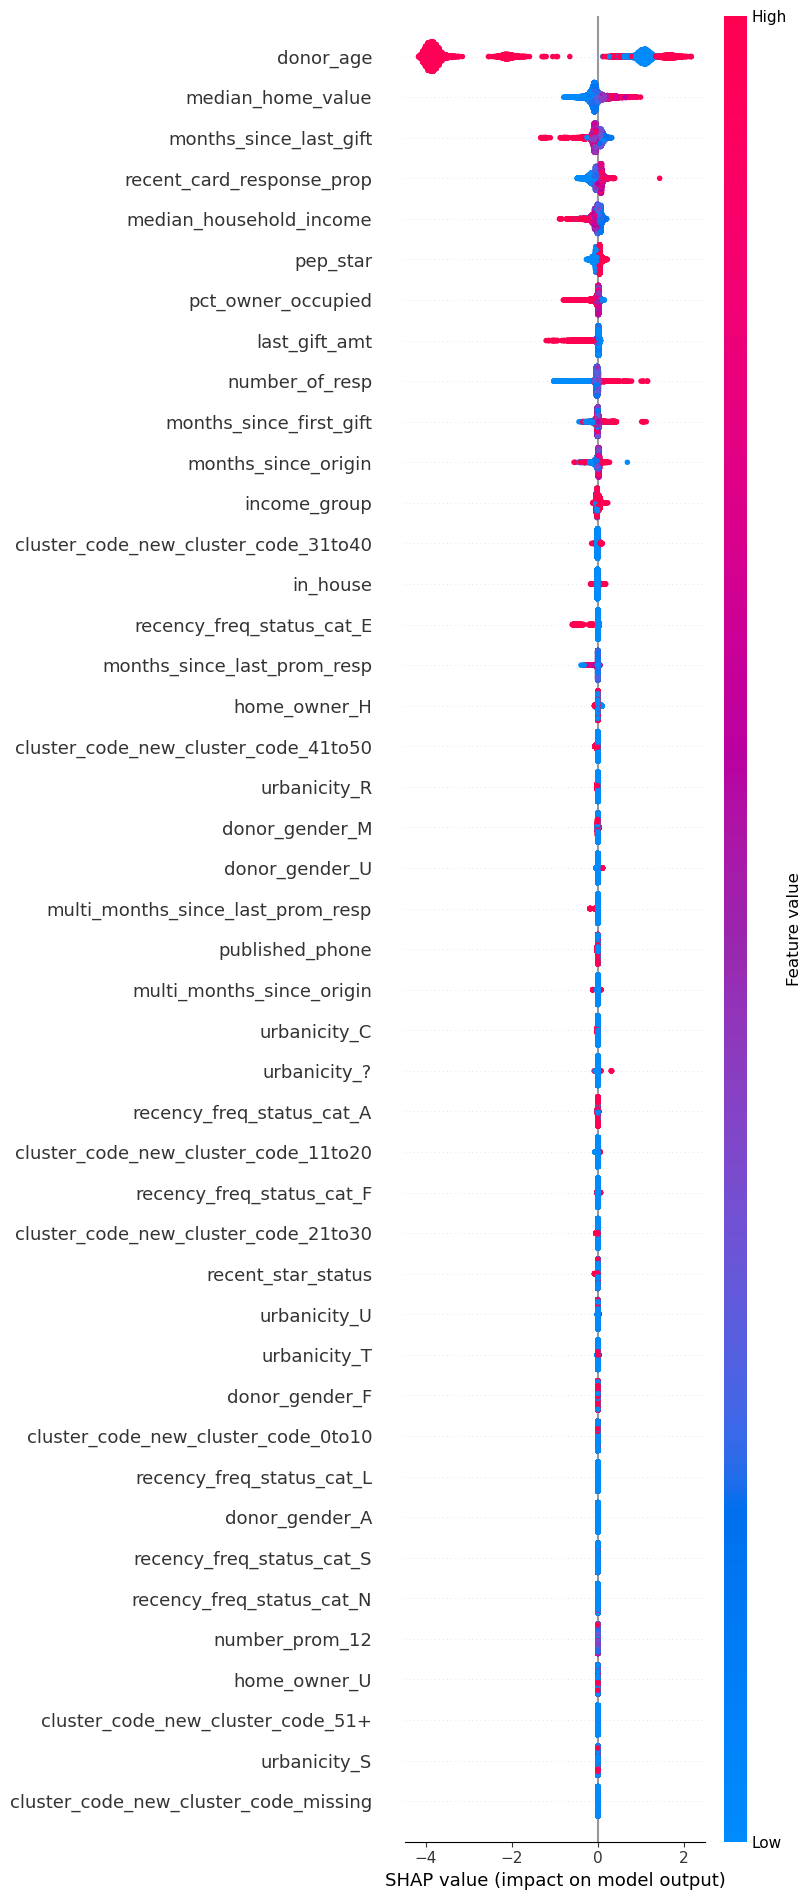

In [560]:
shap.summary_plot(shap_values_xg, X_train.iloc[:,1:], max_display = X_train.iloc[:,1:].shape[1])

In [553]:
feat_imp_1 = grid_search.best_estimator_.feature_importances_

xgb_cols = X_train.columns
feat_imp_1.shape

(44,)

In [554]:

xgb_cols = xgb_cols.drop('control_number')

In [555]:
feat_list_1 = []
total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(xgb_cols, feat_imp_1):
    feat_list_1.append(feature)
    total_importance += feature[1]

In [558]:
df_imp_xg_1 = pd.DataFrame(feat_list_1, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp_xg_1['SUMMED_TOTAL'] = df_imp_xg_1['IMPORTANCE'].cumsum()
df_imp_xg_1.head(18)

,FEATURE,IMPORTANCE,SUMMED_TOTAL
2,donor_age,0.416909,0.416909
36,donor_gender_U,0.033724,0.450633
9,pep_star,0.032163,0.482795
28,recency_freq_status_cat_E,0.030114,0.512909
6,median_home_value,0.027541,0.540450
35,donor_gender_M,0.025099,0.565549
15,months_since_last_gift,0.024476,0.590024
8,pct_owner_occupied,0.023525,0.613550
7,median_household_income,0.023065,0.636614
1,number_of_resp,0.021076,0.657690


The above 18 top features do provide 80% reasoning for the donation probability (based on feature importance).


Using the **top features** from the feature importance to plot and verify the donation distribution: 

In [566]:
top10 = ['donor_age',
'donor_gender_U',
'pep_star',
'recency_freq_status_cat_E',
'median_home_value',
'donor_gender_M',
'months_since_last_gift',
'pct_owner_occupied',
'median_household_income',
'number_of_resp',
'urbanicity_R'
]

In [677]:
df_final[df_final.donor_age>0].donor_age.median()

60.0

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


<Axes: xlabel='donor_age', ylabel='Count'>

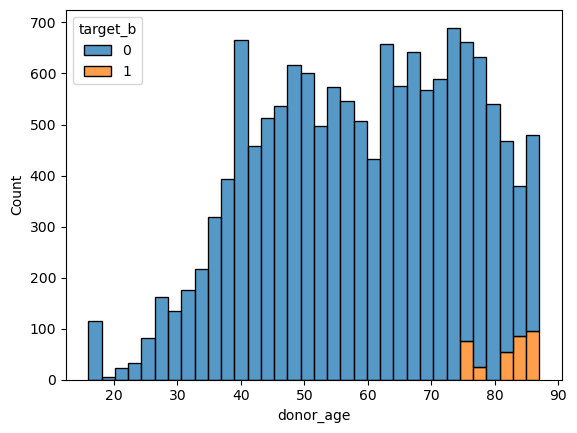

In [576]:
sns.histplot(data=df_final[df_final.donor_age>0], x="donor_age", hue="target_b",multiple="stack")

From the above graph, it is clear that age is a driving factor in the donation analysis.

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


<Axes: xlabel='donor_age', ylabel='Count'>

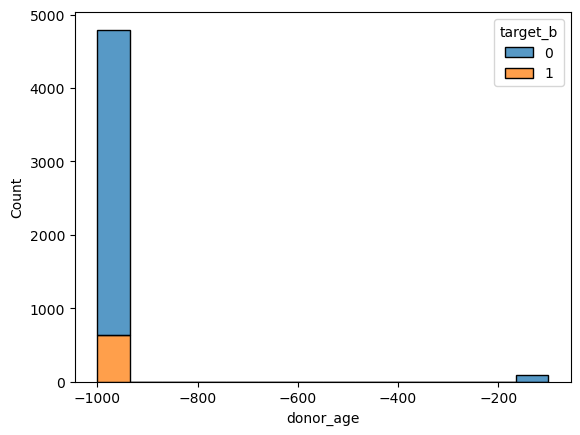

In [577]:
sns.histplot(data=df_final[df_final.donor_age<0], x="donor_age", hue="target_b",multiple="stack")

**Further analysis on the above graph is required**

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
Converting input from bool to <class 'numpy.uint8'> for compatibility.
Converting input from bool to <class 'numpy.uint8'> for compatibility.


<Axes: xlabel='donor_gender_U', ylabel='Count'>

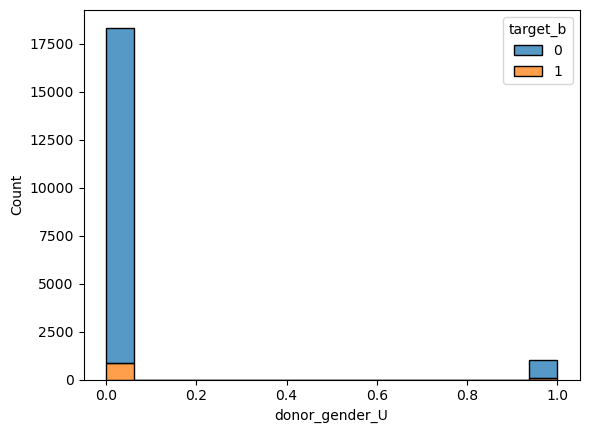

In [578]:
sns.histplot(data=df_final, x="donor_gender_U", hue="target_b",multiple="stack")

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


<Axes: xlabel='pep_star', ylabel='Count'>

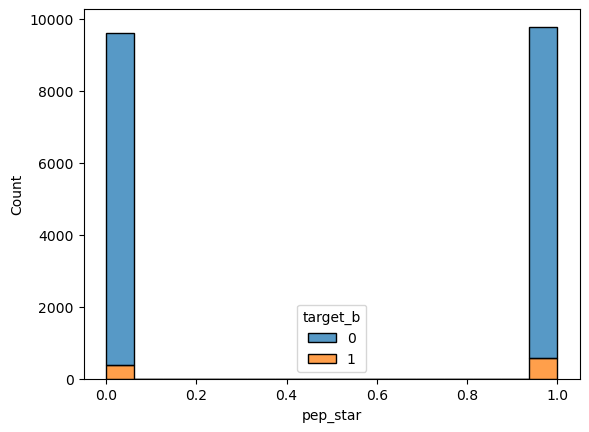

In [579]:
sns.histplot(data=df_final, x="pep_star", hue="target_b",multiple="stack")

THe above graph is consistent with the shap summary plot which has rated pep_star below compared to the feature importance

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
Converting input from bool to <class 'numpy.uint8'> for compatibility.
Converting input from bool to <class 'numpy.uint8'> for compatibility.


<Axes: xlabel='recency_freq_status_cat_E', ylabel='Count'>

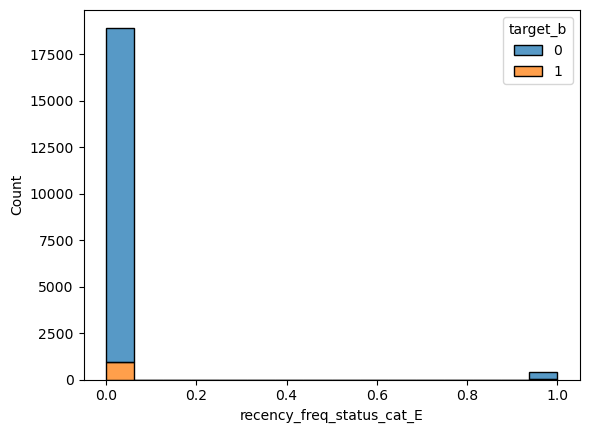

In [580]:
sns.histplot(data=df_final, x="recency_freq_status_cat_E", hue="target_b",multiple="stack")

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


<Axes: xlabel='median_home_value', ylabel='Count'>

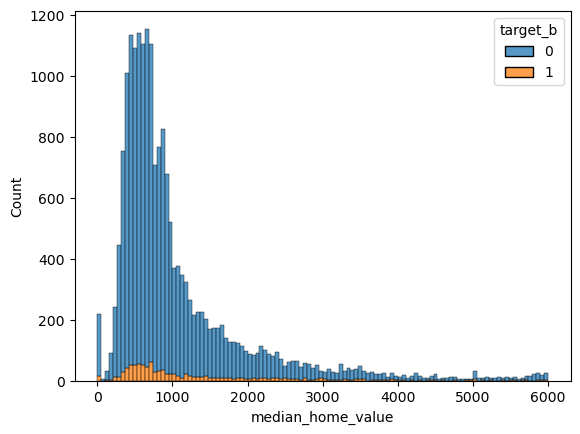

In [581]:
sns.histplot(data=df_final, x="median_home_value", hue="target_b",multiple="stack")

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
Converting input from bool to <class 'numpy.uint8'> for compatibility.
Converting input from bool to <class 'numpy.uint8'> for compatibility.


<Axes: xlabel='donor_gender_M', ylabel='Count'>

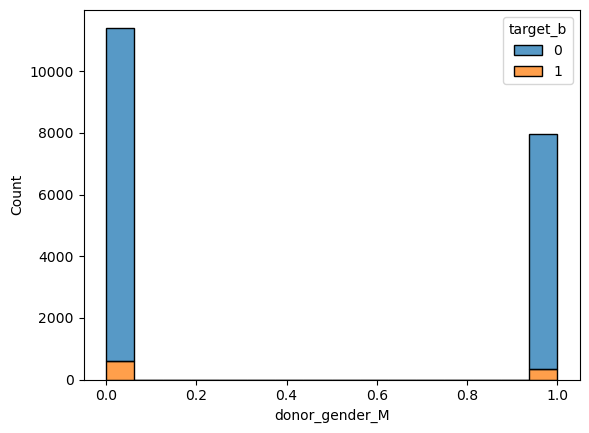

In [582]:
sns.histplot(data=df_final, x="donor_gender_M", hue="target_b",multiple="stack")

THe above graph is consistent with the shap summary plot which has rated donor_gender_M below compared to the feature importance

Plotting variables based on **Shap summary** values:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


<Axes: xlabel='months_since_last_gift', ylabel='Count'>

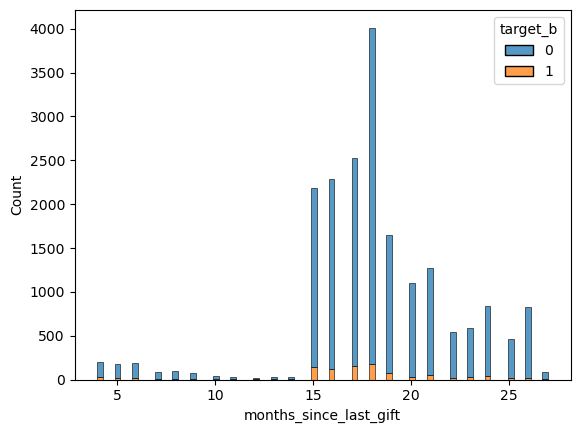

In [585]:
sns.histplot(data=df_final, x="months_since_last_gift", hue="target_b",multiple="stack")

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


<Axes: xlabel='recent_card_response_prop', ylabel='Count'>

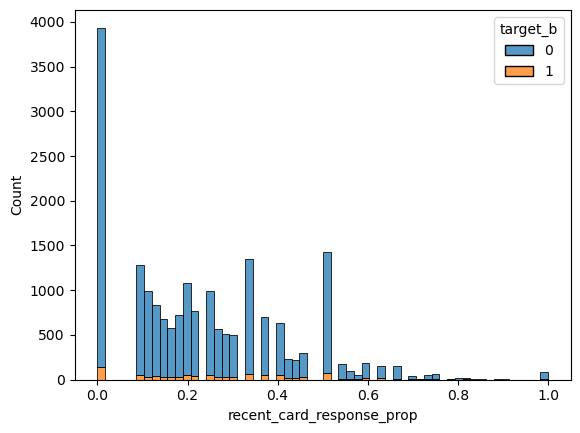

In [586]:
sns.histplot(data=df_final, x="recent_card_response_prop", hue="target_b",multiple="stack")

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


<Axes: xlabel='median_household_income', ylabel='Count'>

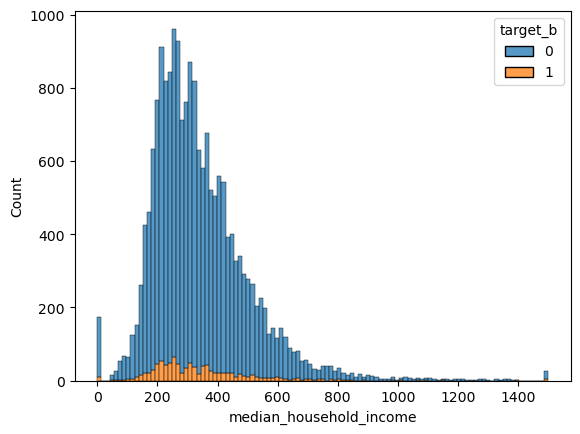

In [587]:
sns.histplot(data=df_final, x="median_household_income", hue="target_b",multiple="stack")

Based on the graphs above, we can say that the model explained by SHAP does a decent job in explaining the tree model. The final important 15 variables:


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


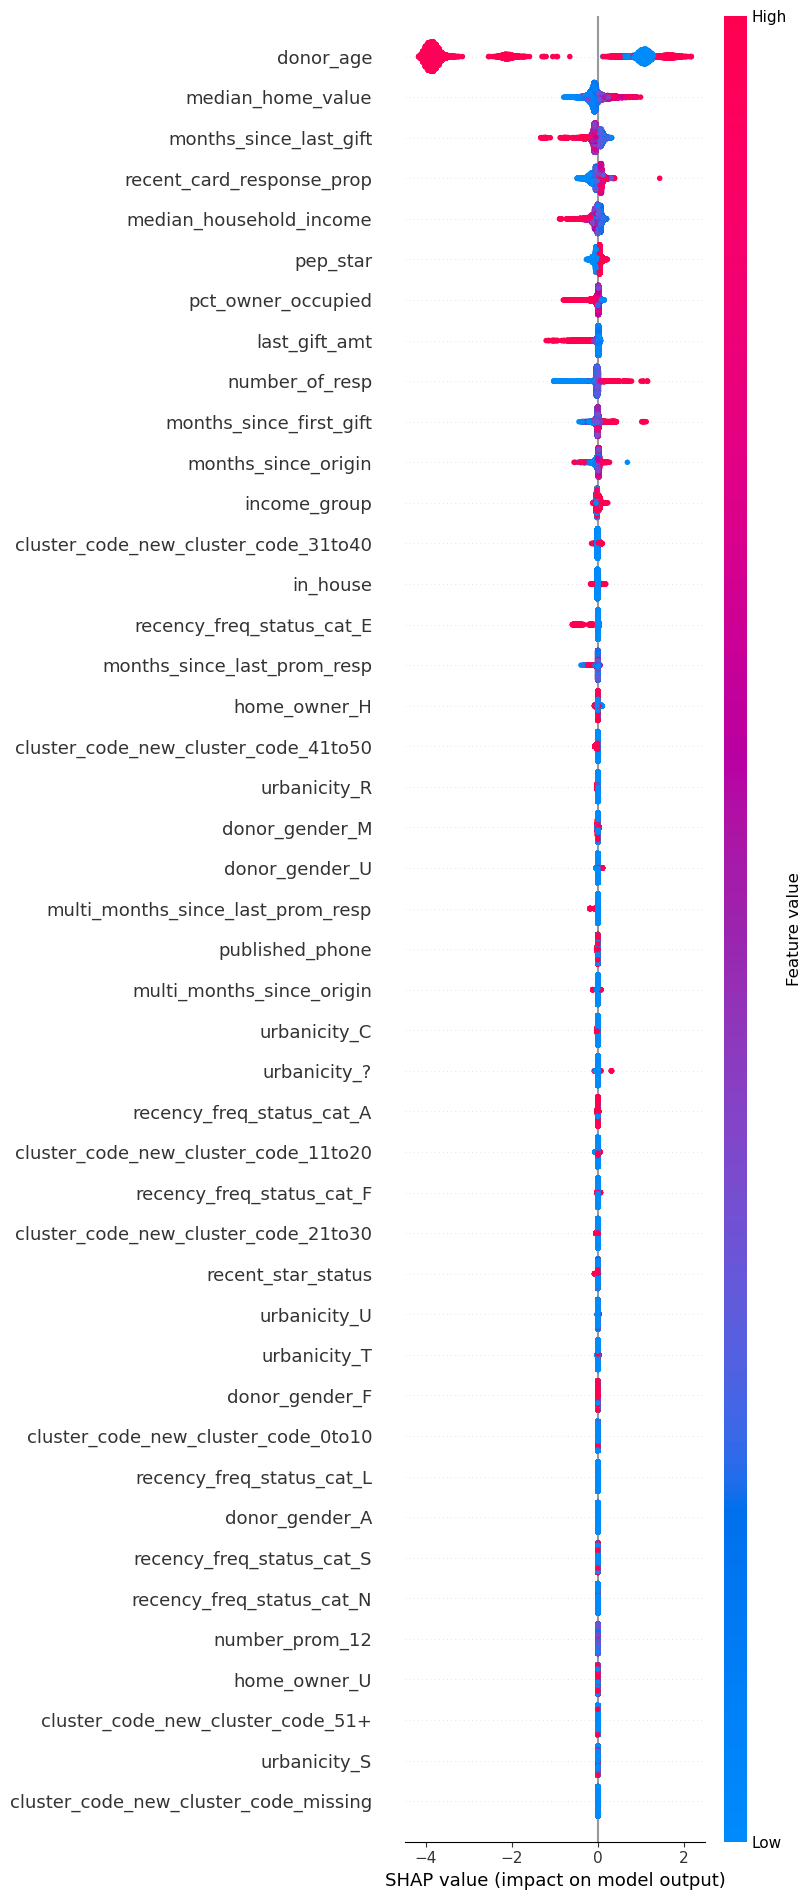

In [588]:
shap.summary_plot(shap_values_xg, X_train.iloc[:,1:], max_display = X_train.iloc[:,1:].shape[1])

In [590]:
Top16_shap = ['donor_age',
'pep_star',
'recency_freq_status_cat_E',
'median_home_value',
'months_since_last_gift',
'pct_owner_occupied',
'median_household_income',
'number_of_resp',
'months_since_last_prom_resp',
'last_gift_amt',
'recent_card_response_prop',
'income_group',
'months_since_origin',
'in_house',
'months_since_first_gift',
'cluster_code_new_cluster_code_31to40'   
    
]

In [589]:
# df_imp_xg_1.to_csv('fimp_xg_1.csv', index=False)

In [592]:
df_shap_xg_1 = df_imp_xg_1[df_imp_xg_1.FEATURE.isin(Top16_shap)]
df_shap_xg_1['SUMMED_TOTAL'] = df_shap_xg_1['IMPORTANCE'].cumsum()

In [595]:
df_shap_xg_1

,FEATURE,IMPORTANCE,SUMMED_TOTAL
2,donor_age,0.416909,0.416909
9,pep_star,0.032163,0.449072
28,recency_freq_status_cat_E,0.030114,0.479186
6,median_home_value,0.027541,0.506726
15,months_since_last_gift,0.024476,0.531202
8,pct_owner_occupied,0.023525,0.554727
7,median_household_income,0.023065,0.577792
1,number_of_resp,0.021076,0.598868
12,months_since_last_prom_resp,0.019134,0.618002
13,last_gift_amt,0.018208,0.636210


The above **top 16** shap variables contribute to 73% of the tree model. These are the variables that would explain the probability of prediction whether the user will donate or not donate

In [598]:
# save model
with open('xgboost_1.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)

In [601]:
# save standardization
with open('xgboost_1_standardization.pkl', 'wb') as f:
    pickle.dump(sc, f)

In [599]:
with open('xgboost_1.pkl', 'rb') as f:
    prediction_model = pickle.load(f)

In [602]:
with open('xgboost_1_standardization.pkl', 'rb') as f:
    prediction_standardization = pickle.load(f)

# In model Validation step, imputing **donor_age** variable did not look a good approach (especially giving it a -1000 value)

C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if

<Axes: xlabel='donor_age', ylabel='Count'>

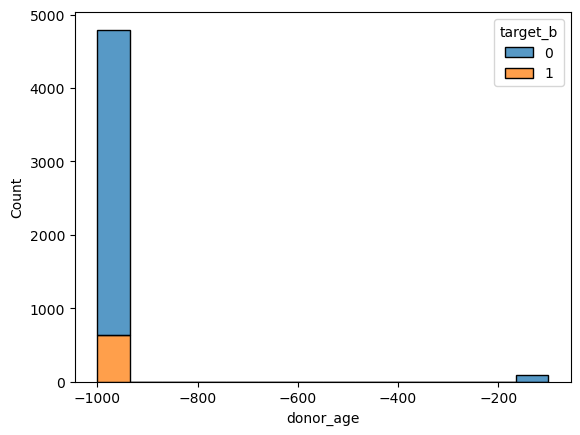

In [63]:
sns.histplot(data=df_final[df_final.donor_age<0], x="donor_age", hue="target_b",multiple="stack")

From the above graph, as age is important variable, imputing it to a negative value is not a good idea.
Essentially from the 969 actual donors, around 634 having missing age

In [65]:
df_final[df_final.donor_age<0].target_b.value_counts()

target_b
0    4255
1     634
Name: count, dtype: int64

In [66]:
print('total customers who donated: ',df_final.target_b.sum())

total customers who donated:  969


In [67]:
print('total customers who donated and have missing age : ', df_final[df_final.donor_age<0].target_b.sum() )

total customers who donated and have missing age :  634


As age is the most important variable in the model above, having 65% ( 634 / 969) **null** data is not a good indicator 

Using KNN imputer for missing age using correlated variables

In [724]:
corr_matrix_age = df_final.drop(columns =['control_number']).corr()['donor_age']

In [725]:
corr_matrix_age = corr_matrix_age.reset_index()
corr_matrix_age['donor_age']  = abs(corr_matrix_age['donor_age'] )
corr_matrix_age.sort_values(by='donor_age', ascending=False, inplace=True)

In [726]:
corr_matrix_age

,index,donor_age
3,donor_age,1.000000
5,income_group,0.447216
26,home_owner_H,0.395925
27,home_owner_U,0.395925
0,target_b,0.212017
6,published_phone,0.187696
37,donor_gender_U,0.162317
29,recency_freq_status_cat_E,0.117757
17,months_since_first_gift,0.109584
22,urbanicity_R,0.081849


Not strongly correlated .. using KNN impute

In [68]:
from sklearn.impute import KNNImputer

In [69]:
df_final_cal_age = df_final.copy()

In [70]:
df_final_cal_age.loc[df_final_cal_age.donor_age >0, 'donor_age_cal'] = df_final_cal_age.donor_age

In [71]:
df_final_cal_age.donor_age_cal.isnull().sum()

4889

In [72]:
del df_final_cal_age['donor_age']

In [746]:
df_final.columns

Index(['target_b', 'control_number', 'months_since_origin', 'number_of_resp',
       'donor_age', 'in_house', 'income_group', 'published_phone',
       'median_home_value', 'median_household_income', 'pct_owner_occupied',
       'pep_star', 'recent_star_status', 'recent_card_response_prop',
       'months_since_last_prom_resp', 'last_gift_amt', 'number_prom_12',
       'months_since_last_gift', 'months_since_first_gift',
       'multi_months_since_last_prom_resp', 'multi_months_since_origin',
       'urbanicity_?', 'urbanicity_C', 'urbanicity_R', 'urbanicity_S',
       'urbanicity_T', 'urbanicity_U', 'home_owner_H', 'home_owner_U',
       'recency_freq_status_cat_A', 'recency_freq_status_cat_E',
       'recency_freq_status_cat_F', 'recency_freq_status_cat_L',
       'recency_freq_status_cat_N', 'recency_freq_status_cat_S',
       'donor_gender_A', 'donor_gender_F', 'donor_gender_M', 'donor_gender_U',
       'cluster_code_new_cluster_code_0to10',
       'cluster_code_new_cluster_code_11

In [78]:
imputer_knn_age = KNNImputer(n_neighbors = 5,add_indicator=True)


Using logic, attempting to impute age using KNN

In [73]:
df_temp_knn_age = df_final_cal_age[['donor_age_cal','median_home_value','in_house',
                  'median_household_income','pep_star',
                  'published_phone','urbanicity_?','urbanicity_?','urbanicity_C','urbanicity_R','urbanicity_T','urbanicity_U']]

In [76]:
df_temp_knn_age

,donor_age_cal,median_home_value,in_house,median_household_income,pep_star,published_phone,urbanicity_?,urbanicity_?,urbanicity_C,urbanicity_R,urbanicity_T,urbanicity_U
0,51.0,854,0,408,0,1,False,False,False,False,True,False
1,69.0,269,0,224,1,1,False,False,False,True,False,False
2,59.0,645,0,288,1,1,False,False,False,True,False,False
3,55.0,0,0,181,0,1,False,False,False,False,False,True
4,76.0,557,0,186,1,1,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
19367,51.0,890,0,454,0,1,False,False,False,False,False,False
19368,NaN,963,0,412,0,0,False,False,False,False,True,False
19369,48.0,1026,0,452,1,1,False,False,False,False,False,True
19370,52.0,4457,0,496,1,0,False,False,False,False,False,False


In [79]:
imputed_data = imputer_knn_age.fit_transform(df_temp_knn_age)  # impute all the missing data
df_temp = pd.DataFrame(imputed_data)


C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Sparse

In [80]:
df_temp.rename(columns={0:'age',12:'imputed'},inplace=True)

In [81]:
df_temp

,age,1,2,3,4,5,6,7,8,9,10,11,imputed
0,51.0,854.0,0.0,408.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,69.0,269.0,0.0,224.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,59.0,645.0,0.0,288.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,55.0,0.0,0.0,181.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,76.0,557.0,0.0,186.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19367,51.0,890.0,0.0,454.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19368,52.2,963.0,0.0,412.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
19369,48.0,1026.0,0.0,452.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19370,52.0,4457.0,0.0,496.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
df_final_cal_age['donor_age_cal'] = df_temp['age'] 

In [83]:
df_final_cal_age['imputed_age'] = df_temp['imputed'] 

In [84]:
df_final_cal_age_copy = df_final_cal_age.copy()

In [85]:
del df_final_cal_age['imputed_age'] 
df_final_cal_age

,target_b,control_number,months_since_origin,number_of_resp,in_house,income_group,published_phone,median_home_value,median_household_income,pct_owner_occupied,pep_star,recent_star_status,recent_card_response_prop,months_since_last_prom_resp,last_gift_amt,number_prom_12,months_since_last_gift,months_since_first_gift,multi_months_since_last_prom_resp,multi_months_since_origin,urbanicity_?,urbanicity_C,urbanicity_R,urbanicity_S,urbanicity_T,urbanicity_U,home_owner_H,home_owner_U,recency_freq_status_cat_A,recency_freq_status_cat_E,recency_freq_status_cat_F,recency_freq_status_cat_L,recency_freq_status_cat_N,recency_freq_status_cat_S,donor_gender_A,donor_gender_F,donor_gender_M,donor_gender_U,cluster_code_new_cluster_code_0to10,cluster_code_new_cluster_code_11to20,cluster_code_new_cluster_code_21to30,cluster_code_new_cluster_code_31to40,cluster_code_new_cluster_code_41to50,cluster_code_new_cluster_code_51+,cluster_code_new_cluster_code_missing,donor_age_cal
0,0,134703,53,12,0,3.0,1,854,408,89,0,0,0.111,-12.0,12.0,12,17,53,-1000.0,-1000.0,False,False,False,False,True,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,51.0
1,0,58351,89,14,0,5.0,1,269,224,81,1,0,0.375,-11.0,11.0,14,18,78,-1000.0,-1000.0,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,69.0
2,0,104133,137,12,0,2.0,1,645,288,90,1,0,0.000,-11.0,11.0,12,20,116,-1000.0,-1000.0,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,59.0
3,0,83486,41,12,0,1.0,1,0,181,0,0,0,0.200,-10.0,10.0,12,18,41,-1000.0,-1000.0,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,55.0
4,0,1909,125,18,0,1.0,1,557,186,76,1,1,0.364,-10.0,10.0,18,16,122,-1000.0,-1000.0,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19367,0,83966,307,10,0,5.0,1,890,454,92,0,0,0.000,18.0,0.0,10,20,20,-1000.0,-1000.0,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,51.0
19368,0,8358,315,7,0,-1000.0,0,963,412,78,0,0,0.000,18.0,0.0,7,27,111,-1000.0,-1000.0,False,False,False,False,True,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,52.2
19369,0,121581,431,13,0,-1000.0,1,1026,452,37,1,1,0.000,18.0,0.0,13,23,62,-1000.0,-1000.0,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,48.0
19370,0,147386,515,13,0,5.0,0,4457,496,74,1,0,0.000,18.0,0.0,13,18,128,-1000.0,-1000.0,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,52.0


C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if

<Axes: xlabel='donor_age_cal', ylabel='Count'>

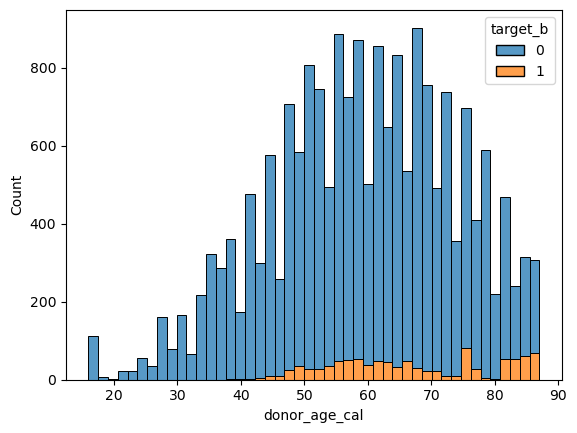

In [86]:
sns.histplot(data=df_final_cal_age, x="donor_age_cal", hue="target_b",multiple="stack")

The above appears to be a better age distribution for prediction

In [87]:
df_final_cal_age.donor_age_cal.mean()
df_final_cal_age.donor_age_cal.median()
# mean / median is preserved

60.0

# all preprocessing steps including KNN for age:

In [ ]:
def apply_all_preprocessing_a(df):
    


    df.columns = map(str.lower,df.columns)


    df_duplicated = df[df.duplicated(['control_number'],keep = False)]

    df_clean = df.copy()
    df_clean = df_clean.drop_duplicates(subset='control_number',keep='first')

    df_duplicated_join = df_duplicated.groupby('control_number').agg({'months_since_last_prom_resp':'nunique','months_since_origin':'nunique' }).reset_index()

    df_duplicated_join.rename(columns={'months_since_last_prom_resp': 'multi_months_since_last_prom_resp', 'months_since_origin':'multi_months_since_origin'}, inplace=True)

    df = df_clean.merge(df_duplicated_join, on ='control_number', how= 'left')



    df.loc[df.last_gift_amt<0,'last_gift_amt'] = -(df.last_gift_amt)
    df.loc[df.months_since_last_prom_resp<0,'last_gift_amt'] = -(df.months_since_last_prom_resp)

    df.multi_months_since_last_prom_resp.fillna(value=-1000,inplace=True)
    df.multi_months_since_origin.fillna(value=-1000,inplace=True)

    df1 = df.copy()


    df1.loc[df1.donor_age<16, 'donor_age'] = -100

    #df1['donor_age'].fillna(value = -1000,inplace=True)

    df1['income_group'].fillna(value = -1000,inplace=True)


    df1.loc[(df1.cluster_code>=0) & (df1.cluster_code<=10),'cluster_code_new']= 'cluster_code_0to10'
    df1.loc[(df1.cluster_code>10) & (df1.cluster_code<=20),'cluster_code_new']= 'cluster_code_11to20'
    df1.loc[(df1.cluster_code>20) & (df1.cluster_code<=30),'cluster_code_new']= 'cluster_code_21to30'
    df1.loc[(df1.cluster_code>30) & (df1.cluster_code<=40),'cluster_code_new']= 'cluster_code_31to40'
    df1.loc[(df1.cluster_code>40) & (df1.cluster_code<=50),'cluster_code_new']= 'cluster_code_41to50'
    df1.loc[(df1.cluster_code>50) ,'cluster_code_new']= 'cluster_code_51+'
    df1.loc[(df1.cluster_code_new.isnull()) | (df1.cluster_code_new == 'nan'),'cluster_code_new'] = 'cluster_code_missing'

    df1['recency_freq_status_cat'] = df1.recency_freq_status.str[0]


    cat_columns = ['urbanicity','home_owner','recency_freq_status_cat','donor_gender','cluster_code_new']
    df_categoried = pd.get_dummies(df1,prefix_sep='_', columns = cat_columns)


    drop_columns = ['recency_freq_status','wealth_rating','cluster_code']

    df_categoried.drop(drop_columns,inplace=True,axis=1)

    #  Using the same value as in training dataset
    df_categoried['months_since_last_prom_resp'].fillna(value=18.0,inplace=True)


    df_categoried['last_gift_amt'].fillna(value=20.0,inplace=True)

    df_dollar_var = df_categoried[['control_number','target_d6','target_d12','target_d18','target_d24']]

    drop_dollar = ['target_d6','target_d12','target_d18','target_d24']

    df_final = df_categoried.drop(drop_dollar, axis=1)

    df_final_cal_age = df_final.copy()


    df_final_cal_age.loc[df_final_cal_age.donor_age >0, 'donor_age_cal'] = df_final_cal_age.donor_age
    del df_final_cal_age['donor_age']
 
    df_temp_knn_age = df_final_cal_age[['donor_age_cal','median_home_value','in_house',
                  'median_household_income','pep_star',
                  'published_phone','urbanicity_?','urbanicity_?','urbanicity_C','urbanicity_R','urbanicity_T','urbanicity_U']]
 
    imputed_data = prediction_knn.transform(df_temp_knn_age)
    df_temp = pd.DataFrame(imputed_data)
    df_temp.rename(columns={0:'age',12:'imputed'},inplace=True)
    df_final_cal_age['donor_age_cal'] = df_temp['age'] 
    #df_final_cal_age['imputed_age'] = df_temp['imputed'] 

    col_to_standardize = ['months_since_origin',
    'number_of_resp',
    'donor_age_cal',
    'income_group',
    'published_phone',
    'median_home_value',
    'median_household_income',
    'pct_owner_occupied',
    'months_since_last_prom_resp',
    'last_gift_amt',
    'number_prom_12',
    'months_since_last_gift',
    'months_since_first_gift',
    'multi_months_since_last_prom_resp',
    'multi_months_since_origin'
    ]


    df_final_cal_age[col_to_standardize] = prediction_standardization.transform(df_final_cal_age[col_to_standardize])

    return df_final_cal_age

# reload data and previously saved pickle file due to crash

In [148]:
df_final_cal_age = apply_all_preprocessing_a(df)


with open('xgboost_2age_standardization.pkl', 'rb') as f:
    prediction_standardization = pickle.load(f)

with open('xgboost_imputer_knn_age.pkl', 'rb') as f:
    prediction_knn = pickle.load(f)    

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'cluster_code_0to10' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


In [88]:
df_final_cal_age

,target_b,control_number,months_since_origin,number_of_resp,in_house,income_group,published_phone,median_home_value,median_household_income,pct_owner_occupied,pep_star,recent_star_status,recent_card_response_prop,months_since_last_prom_resp,last_gift_amt,number_prom_12,months_since_last_gift,months_since_first_gift,multi_months_since_last_prom_resp,multi_months_since_origin,urbanicity_?,urbanicity_C,urbanicity_R,urbanicity_S,urbanicity_T,urbanicity_U,home_owner_H,home_owner_U,recency_freq_status_cat_A,recency_freq_status_cat_E,recency_freq_status_cat_F,recency_freq_status_cat_L,recency_freq_status_cat_N,recency_freq_status_cat_S,donor_gender_A,donor_gender_F,donor_gender_M,donor_gender_U,cluster_code_new_cluster_code_0to10,cluster_code_new_cluster_code_11to20,cluster_code_new_cluster_code_21to30,cluster_code_new_cluster_code_31to40,cluster_code_new_cluster_code_41to50,cluster_code_new_cluster_code_51+,cluster_code_new_cluster_code_missing,donor_age_cal
0,0,134703,53,12,0,3.0,1,854,408,89,0,0,0.111,-12.0,12.0,12,17,53,-1000.0,-1000.0,False,False,False,False,True,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,51.0
1,0,58351,89,14,0,5.0,1,269,224,81,1,0,0.375,-11.0,11.0,14,18,78,-1000.0,-1000.0,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,69.0
2,0,104133,137,12,0,2.0,1,645,288,90,1,0,0.000,-11.0,11.0,12,20,116,-1000.0,-1000.0,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,59.0
3,0,83486,41,12,0,1.0,1,0,181,0,0,0,0.200,-10.0,10.0,12,18,41,-1000.0,-1000.0,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,55.0
4,0,1909,125,18,0,1.0,1,557,186,76,1,1,0.364,-10.0,10.0,18,16,122,-1000.0,-1000.0,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19367,0,83966,307,10,0,5.0,1,890,454,92,0,0,0.000,18.0,0.0,10,20,20,-1000.0,-1000.0,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,51.0
19368,0,8358,315,7,0,-1000.0,0,963,412,78,0,0,0.000,18.0,0.0,7,27,111,-1000.0,-1000.0,False,False,False,False,True,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,52.2
19369,0,121581,431,13,0,-1000.0,1,1026,452,37,1,1,0.000,18.0,0.0,13,23,62,-1000.0,-1000.0,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,48.0
19370,0,147386,515,13,0,5.0,0,4457,496,74,1,0,0.000,18.0,0.0,13,18,128,-1000.0,-1000.0,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,52.0


In [150]:
with open('catboost_age_impute.pkl', 'rb') as f:
    prediction_model = pickle.load(f)

In [89]:
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(df_final_cal_age.iloc[:,1:], df_final_cal_age.iloc[:,0],stratify=df_final_cal_age.iloc[:,0], test_size=0.2, random_state=0)

C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [90]:
print('X_train_a: ',X_train_a.shape)
print('y_train_a: ',y_train_a.sum())
print('Ratio train: ',y_train_a.sum()/X_train_a.shape[0]*100,'%')
print('X_test_a: ',X_test_a.shape)
print('y_test_a: ',y_test_a.sum())
print('Ratio test: ',y_test_a.sum()/X_test_a.shape[0]*100,'%')

X_train_a:  (15497, 45)
y_train_a:  775
Ratio train:  5.000967929276634 %
X_test_a:  (3875, 45)
y_test_a:  194
Ratio test:  5.006451612903226 %


In [91]:
col_to_standardize_a = ['months_since_origin',
'number_of_resp',
'donor_age_cal',
'income_group',
'published_phone',
'median_home_value',
'median_household_income',
'pct_owner_occupied',
'months_since_last_prom_resp',
'last_gift_amt',
'number_prom_12',
'months_since_last_gift',
'months_since_first_gift',
'multi_months_since_last_prom_resp',
'multi_months_since_origin'
]

In [92]:
sc_age = StandardScaler()
X_train_a[col_to_standardize_a] = sc_age.fit_transform(X_train_a[col_to_standardize_a])
X_test_a[col_to_standardize_a] = sc_age.transform(X_test_a[col_to_standardize_a])

C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Sparse

In [93]:
# save standardization
with open('xgboost_2age_standardization.pkl', 'wb') as f:
    pickle.dump(sc_age, f)

In [257]:

# catboost classifier
estimator = CatBoostClassifier(
#      objective= 'binary:logistic',
task_type='CPU',
    random_state=1
)

parameters_a = {
#     'max_depth':  [3,5,8],
    'max_depth':  [3],
#  'n_estimators': [100,150,200,250],
     'n_estimators': [200],
#         'iterations': [750,1000,1250],
#             'iterations': [750],
    'learning_rate': [0.1],
#     'scale_pos_weight' : [10,15,20]
        'scale_pos_weight' : [15]
}
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [258]:
grid_search_age = GridSearchCV(
    estimator=estimator,
    param_grid=parameters_a,
    scoring = 'f1',
    n_jobs = 10,
    cv = kfold,
    verbose=True
)

grid_search_age.fit(X_train_a.drop(columns =['control_number']), y_train_a)

grid_search_age.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


0:	learn: 0.6765352	total: 3.22ms	remaining: 641ms
1:	learn: 0.6572502	total: 6.88ms	remaining: 681ms
2:	learn: 0.6459820	total: 10.7ms	remaining: 705ms
3:	learn: 0.6330405	total: 13.9ms	remaining: 680ms
4:	learn: 0.6247863	total: 17.2ms	remaining: 671ms
5:	learn: 0.6140519	total: 20.5ms	remaining: 662ms
6:	learn: 0.6074867	total: 23.5ms	remaining: 648ms
7:	learn: 0.6010170	total: 26.5ms	remaining: 637ms
8:	learn: 0.5960684	total: 29.4ms	remaining: 624ms
9:	learn: 0.5936375	total: 32.7ms	remaining: 621ms
10:	learn: 0.5896369	total: 35.6ms	remaining: 611ms
11:	learn: 0.5882393	total: 39ms	remaining: 611ms
12:	learn: 0.5848281	total: 42ms	remaining: 604ms
13:	learn: 0.5834582	total: 44.8ms	remaining: 595ms
14:	learn: 0.5791168	total: 48.1ms	remaining: 593ms
15:	learn: 0.5774831	total: 51.1ms	remaining: 588ms
16:	learn: 0.5748117	total: 54.6ms	remaining: 588ms
17:	learn: 0.5723869	total: 58ms	remaining: 587ms
18:	learn: 0.5694401	total: 61.2ms	remaining: 583ms
19:	learn: 0.5675739	total: 

168:	learn: 0.4470376	total: 607ms	remaining: 111ms
169:	learn: 0.4464767	total: 612ms	remaining: 108ms
170:	learn: 0.4460000	total: 616ms	remaining: 104ms
171:	learn: 0.4451442	total: 620ms	remaining: 101ms
172:	learn: 0.4444853	total: 623ms	remaining: 97.2ms
173:	learn: 0.4438821	total: 627ms	remaining: 93.7ms
174:	learn: 0.4434533	total: 630ms	remaining: 90ms
175:	learn: 0.4429585	total: 633ms	remaining: 86.4ms
176:	learn: 0.4424201	total: 637ms	remaining: 82.8ms
177:	learn: 0.4420267	total: 641ms	remaining: 79.2ms
178:	learn: 0.4415938	total: 644ms	remaining: 75.6ms
179:	learn: 0.4411356	total: 648ms	remaining: 72ms
180:	learn: 0.4408165	total: 652ms	remaining: 68.4ms
181:	learn: 0.4404049	total: 655ms	remaining: 64.8ms
182:	learn: 0.4399661	total: 658ms	remaining: 61.2ms
183:	learn: 0.4394861	total: 662ms	remaining: 57.5ms
184:	learn: 0.4388406	total: 665ms	remaining: 53.9ms
185:	learn: 0.4381858	total: 669ms	remaining: 50.4ms
186:	learn: 0.4377617	total: 673ms	remaining: 46.8ms
1

In [ ]:
print(grid_search_age.cv_results_)
print('\n Best estimator:')
print(grid_search_age.best_estimator_)

print('\n Best score:')
print(grid_search_age.best_score_ )
print('\n Best parameters:')
print(grid_search_age.best_params_)
results = pd.DataFrame(grid_search_age.cv_results_)


In [266]:
y_pred_prob_a = grid_search_age.best_estimator_.predict_proba(X_test_a.drop(columns =['control_number']))
y_pred_a = grid_search_age.best_estimator_.predict(X_test_a.drop(columns =['control_number']))




cm_a = confusion_matrix(y_test_a, y_pred_a)
print(cm_a)
accuracy_score(y_test_a, y_pred_a)

[[3026  655]
 [  69  125]]


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `

0.8131612903225807

In [261]:
with open('catboost_age_impute_f1.pkl', 'wb') as f:
    pickle.dump(grid_search_age, f)

In [262]:
y_pred_a

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

# Using Saved Model result from previous run

In [263]:
with open('catboost_age_impute_best_recall.pkl', 'rb') as f:
    prediction_model_best_recall = pickle.load(f)

In [265]:
y_pred_prob_a = prediction_model_best_recall.predict_proba(X_test_a.drop(columns =['control_number']))
y_pred_a = prediction_model_best_recall.predict(X_test_a.drop(columns =['control_number']))



cm_a = confusion_matrix(y_test_a, y_pred_a)
print(cm_a)
accuracy_score(y_test_a, y_pred_a)

[[1353 2328]
 [  12  182]]


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `

0.3961290322580645

# The above model is the best model based on the recall and True positive rate 

Check if **changning probability threshold** provides any additional insight:

In [267]:
y_pred_a45p = y_pred_prob_a[:,1].copy()

y_pred_a45p = pd.DataFrame(y_pred_a45p,columns = ['new_pred'])

y_pred_a45p.loc[y_pred_a45p.new_pred >=0.45, 'new_pred'] = 1
y_pred_a45p.loc[y_pred_a45p.new_pred !=1, 'new_pred'] = 0

cm_a_45p = confusion_matrix(y_test_a, y_pred_a45p.new_pred)
print(cm_a_45p)
accuracy_score(y_test_a, y_pred_a45p.new_pred)

[[2867  814]
 [  59  135]]


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `

0.7747096774193548

We may be able to gain a little bit more TP at the expense of increase in FP. This can be explored in future analysis

In [268]:
test_data_a =  X_test_a.copy()
test_data_a['target_b'] = y_test_a
test_data_a['y_pred_prob'] = (y_pred_prob_a[:,1])
test_data_a['y_pred'] = (y_pred_a)

In [269]:
test_data_a

,control_number,months_since_origin,number_of_resp,in_house,income_group,published_phone,median_home_value,median_household_income,pct_owner_occupied,pep_star,recent_star_status,recent_card_response_prop,months_since_last_prom_resp,last_gift_amt,number_prom_12,months_since_last_gift,months_since_first_gift,multi_months_since_last_prom_resp,multi_months_since_origin,urbanicity_?,urbanicity_C,urbanicity_R,urbanicity_S,urbanicity_T,urbanicity_U,home_owner_H,home_owner_U,recency_freq_status_cat_A,recency_freq_status_cat_E,recency_freq_status_cat_F,recency_freq_status_cat_L,recency_freq_status_cat_N,recency_freq_status_cat_S,donor_gender_A,donor_gender_F,donor_gender_M,donor_gender_U,cluster_code_new_cluster_code_0to10,cluster_code_new_cluster_code_11to20,cluster_code_new_cluster_code_21to30,cluster_code_new_cluster_code_31to40,cluster_code_new_cluster_code_41to50,cluster_code_new_cluster_code_51+,cluster_code_new_cluster_code_missing,donor_age_cal,target_b,y_pred_prob,y_pred
9203,160674,-0.563208,0.020735,0,-1.848325,-1.000581,0.045253,-0.273000,-1.446220,1,0,0.444,-0.349210,-0.056787,0.020735,-0.544740,-0.653067,-0.162146,-0.162146,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,-1.266224,0,0.145889,0
9972,28778,0.482758,0.020735,0,0.534104,0.999419,-0.810136,-1.111811,0.155685,0,0,0.250,-0.214988,-0.012880,0.020735,-0.050646,1.083903,-0.162146,-0.162146,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,0.596653,0,0.316167,0
6449,4981,0.831414,5.210480,1,-1.848325,-1.000581,2.301029,3.215968,1.025291,1,0,0.100,-0.282099,0.018915,5.210480,-1.285880,1.511465,-0.162146,-0.162146,True,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,0.596653,0,0.699255,1
18990,20782,0.569922,1.966889,0,-1.848325,-1.000581,-0.693870,-1.057106,0.750679,1,0,0.111,-0.282099,0.231774,1.966889,-0.297693,-0.920293,-0.162146,-0.162146,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,-0.010507,0,0.645276,1
4054,100932,-0.563208,-0.627983,0,0.543624,0.999419,-0.319118,0.389539,0.933754,0,0,0.143,-0.282099,-0.056787,-0.627983,-0.297693,-0.786680,-0.162146,-0.162146,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,-1.611201,0,0.007419,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17465,147045,-0.040225,0.020735,0,0.548384,0.999419,0.944241,1.118940,0.796447,1,1,0.222,-0.416321,-0.041647,0.020735,-0.791786,0.175334,-0.162146,-0.162146,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,-0.562471,1,0.396673,0
17013,138719,-0.650372,-0.195504,0,-1.848325,-1.000581,0.465680,1.617364,0.430298,1,1,0.500,0.925901,-0.026507,-0.195504,-0.791786,0.175334,-0.162146,-0.162146,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,-0.700461,1,0.608699,1
4876,64749,-0.214553,0.020735,0,0.548384,0.999419,1.067774,3.374004,1.299903,1,0,0.300,-0.147876,-0.026507,0.020735,0.196400,-0.359118,-0.162146,-0.162146,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,0.182680,0,0.303199,0
18785,23178,-0.214553,0.669453,0,0.538864,-1.000581,-0.617051,-0.625543,-0.347771,1,1,0.100,0.053457,-0.034077,0.669453,-0.050646,-0.359118,-0.162146,-0.162146,False,True,False,False,False,False,True,False,False,Fal

In [270]:
print('#Current Target: ',X_test_a.shape)
print('#Current users who donated: ',y_test_a.sum())
print('%CurrentDonation: ',y_test_a.sum()/X_test_a.shape[0]*100,'%')

print('# Total New users to target: ' ,test_data_a[test_data_a.y_pred==1].shape[0])
print('# Users who donated based on new target strategy: ' ,test_data_a[test_data_a.target_b==1].shape[0])
print('% Donated using new strategy : ', test_data_a[test_data_a.y_pred==1].target_b.sum() / test_data_a[test_data_a.y_pred==1].shape[0] *100,'%'    )

#Current Target:  (3875, 45)
#Current users who donated:  194
%CurrentDonation:  5.006451612903226 %
# Total New users to target:  780
# Users who donated based on new target strategy:  194
% Donated using new strategy :  16.025641025641026 %


The above is showing that the model will give **3x** better results on **test data**

In [38]:
# with open('catboost_age_impute_13.pkl', 'wb') as f:
#     pickle.dump(grid_search_age.best_estimator_, f)

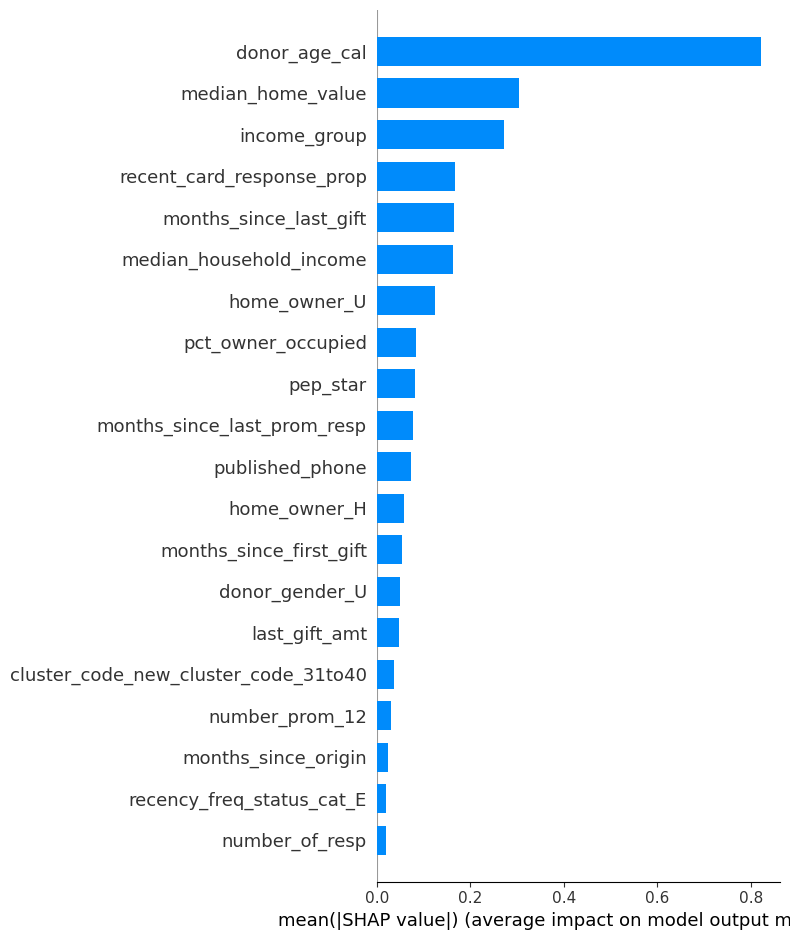

In [271]:
model_xg_a = grid_search_age.best_estimator_
explainer_xg_a = shap.TreeExplainer(model_xg_a)
shap_values_xg_a = explainer_xg_a.shap_values(X_train_a.drop(columns =['control_number']))
shap.summary_plot(shap_values_xg_a, X_train_a.drop(columns =['control_number']), plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


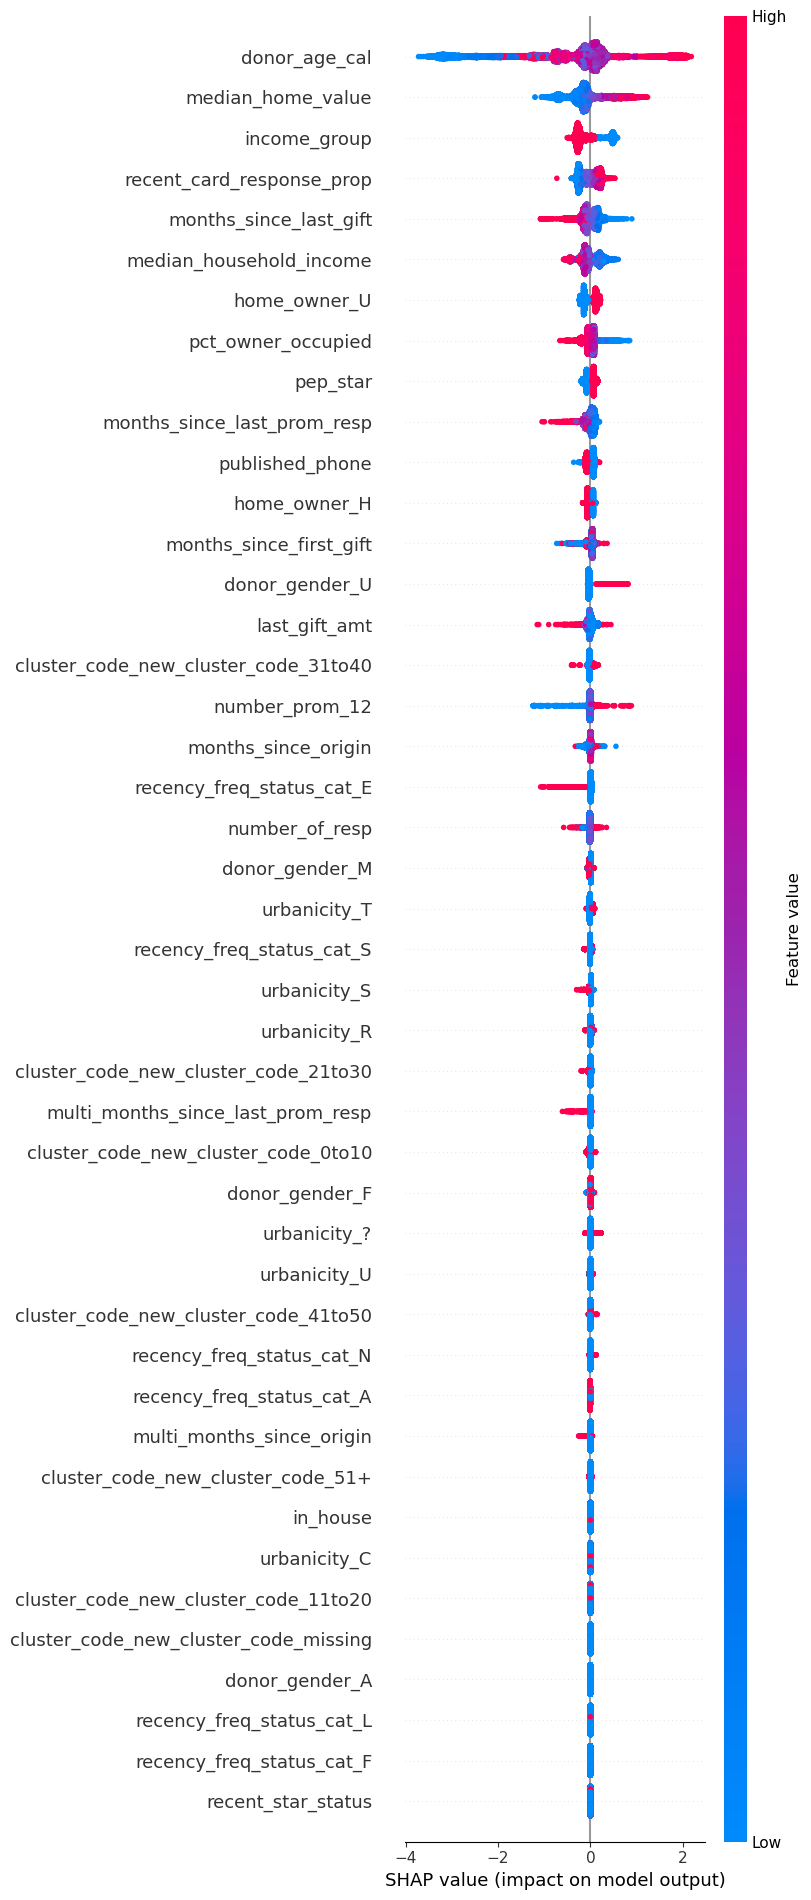

In [272]:
shap.summary_plot(shap_values_xg_a, X_train_a.drop(columns =['control_number']), max_display = X_train_a.drop(columns =['control_number']).shape[1])

In [273]:
Top20_shap_a = [
                'donor_age_cal',
'median_home_value',
    'income_group',
'recent_card_response_prop',
'months_since_last_gift',
'median_household_income',
     'home_owner_U',
'pct_owner_occupied',
'pep_star',
    'months_since_last_prom_resp',
    'published_phone',
     'home_owner_H', 
    'months_since_first_gift',
    'donor_gender_U',
    'last_gift_amt',
'cluster_code_new_cluster_code_31to40',
    'number_prom_12',
'months_since_origin',
    'recency_freq_status_cat_E',
    'number_of_resp' 

]

In [274]:
feat_imp_a = grid_search_age.best_estimator_.feature_importances_

xgb_cols = X_train_a.columns
feat_imp_a.shape
xgb_cols = xgb_cols.drop('control_number')

In [275]:
feat_list_a = []
total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(xgb_cols, feat_imp_a):
    feat_list_a.append(feature)
    total_importance += feature[1]

In [276]:
df_imp_xg_a = pd.DataFrame(feat_list_a, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)

In [277]:
df_shap_xg_a = df_imp_xg_a[df_imp_xg_a.FEATURE.isin(Top20_shap_a)]
df_shap_xg_a['SUMMED_TOTAL'] = df_shap_xg_a['IMPORTANCE'].cumsum()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [278]:
df_shap_xg_a.head(20)

,FEATURE,IMPORTANCE,SUMMED_TOTAL
43,donor_age_cal,51.868188,51.868188
5,median_home_value,7.493302,59.361490
3,income_group,6.022179,65.383669
6,median_household_income,4.261657,69.645326
14,months_since_last_gift,3.487661,73.132987
10,recent_card_response_prop,3.167089,76.300077
15,months_since_first_gift,2.328780,78.628857
11,months_since_last_prom_resp,2.294998,80.923855
25,home_owner_U,2.177725,83.101581
7,pct_owner_occupied,2.145859,85.247440


The above **top 20** shap variables contribute to **97%** of the tree model. These are the variables that would explain the probability of prediction whether the user will donate or not donate

In [281]:
# save model
with open('catboost_age_impute_f1.pkl', 'wb') as f:
    pickle.dump(grid_search_age, f)


    


In [ ]:
# save age knn imputer
with open('xgboost_imputer_knn_age.pkl', 'wb') as f:
    pickle.dump(imputer_knn_age, f)

In [285]:
with open('catboost_age_impute_f1.pkl', 'rb') as f:
    prediction_model = pickle.load(f)

with open('xgboost_2age_standardization.pkl', 'rb') as f:
    prediction_standardization = pickle.load(f)

with open('xgboost_imputer_knn_age.pkl', 'rb') as f:
    prediction_knn = pickle.load(f)    

# Test new data (to get predictions, replace the following test file)	
**test** file can be replaced with any other to find probabilities that the user will donate

In [282]:
file_to_test  = pd.read_excel('SampleDonorData2.xlsx',sheet_name = 'Project Data')

clean_data = apply_all_preprocessing_a(file_to_test)

new_prediction = clean_data.copy()

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'cluster_code_0to10' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


# applying new model to the entire data to see model performance and predictions

In [286]:
y_pred_prob_test = prediction_model.best_estimator_.predict_proba(clean_data.drop(['target_b', 'control_number'], axis=1, errors='ignore'))[:,1]
y_pred_test = prediction_model.best_estimator_.predict(clean_data.drop(['target_b', 'control_number'], axis=1, errors='ignore'))

new_prediction['y_pred_prob'] = pd.Series(y_pred_prob_test)
new_prediction['y_pred'] = pd.Series(y_pred_test)

In [287]:
print(confusion_matrix(new_prediction['target_b'], new_prediction['y_pred']))

[[15188  3215]
 [  234   735]]


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `

In [293]:
print('#Current Target: ',new_prediction.shape[0])
print('#Current users who donated: ',new_prediction['target_b'].sum())
print('%CurrentDonation: ',new_prediction['target_b'].sum()/new_prediction.shape[0]*100,'%')

print('# Total users to target based on new target strategy: ' ,new_prediction[new_prediction.y_pred==1].shape[0])
print('# Users who will donated based on new target strategy: ' ,new_prediction[new_prediction.y_pred==1].target_b.sum())
print('% Donated using new strategy : ', new_prediction[new_prediction.y_pred==1].target_b.sum() / new_prediction[new_prediction.y_pred==1].shape[0] *100,'%'    )

#Current Target:  19372
#Current users who donated:  969
%CurrentDonation:  5.00206483584555 %
# Total users to target based on new target strategy:  3950
# Users who will donated based on new target strategy:  735
% Donated using new strategy :  18.60759493670886 %


**The above results** tell us that if the company use the new strategy, we can observe **3.5x** (5% vs 18.6%) improvement over current strategy. Company will save the capital by **targeting only 20%** (3950/19372) of the existing population and still receive **76%** (735 / 969) of the **current number of donations**. 






# Users to target 

The following will generate a csv file that can be used to target users for the donation. It has 3 columns - 

control_number: identify the user

y_pred_prob: probabity that the user will donate

y_pred: binary predicted target value

In [294]:
new_prediction2[['control_number','y_pred_prob','y_pred']].to_csv('target_users.csv')

# Alternate solution using best recall

In [295]:
with open('catboost_age_impute_best_recall.pkl', 'rb') as f:
    prediction_model_2 = pickle.load(f)

In [296]:
new_prediction2 = clean_data.copy()

y_pred_prob_test2 = prediction_model_2.best_estimator_.predict_proba(clean_data.drop(['target_b', 'control_number'], axis=1, errors='ignore'))[:,1]
y_pred_test2 = prediction_model_2.best_estimator_.predict(clean_data.drop(['target_b', 'control_number'], axis=1, errors='ignore'))

new_prediction2['y_pred_prob'] = pd.Series(y_pred_prob_test2)
new_prediction2['y_pred'] = pd.Series(y_pred_test2)

In [297]:
print(confusion_matrix(new_prediction2['target_b'], new_prediction2['y_pred']))

[[ 6894 11509]
 [   19   950]]


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `

In [298]:
print('#Current Target: ',new_prediction2.shape[0])
print('#Current users who donated: ',new_prediction2['target_b'].sum())
print('%CurrentDonation: ',new_prediction2['target_b'].sum()/new_prediction2.shape[0]*100,'%')

print('# Total users to target based on new target strategy: ' ,new_prediction2[new_prediction2.y_pred==1].shape[0])
print('# Users who will donated based on new target strategy: ' ,new_prediction2[new_prediction2.y_pred==1].target_b.sum())
print('% Donated using new strategy : ', new_prediction2[new_prediction2.y_pred==1].target_b.sum() / new_prediction2[new_prediction2.y_pred==1].shape[0] *100,'%'    )

#Current Target:  19372
#Current users who donated:  969
%CurrentDonation:  5.00206483584555 %
# Total users to target based on new target strategy:  12459
# Users who will donated based on new target strategy:  950
% Donated using new strategy :  7.625010032907937 %


The above results tell us that if the company use the new strategy, we can observe **1.5x** (5% vs 7.6%) improvement over current strategy. Company will save the capital by targeting **60%** (3950/19372) of the existing population and still receive **98%** (950 / 969) of the current number of donations 


# Appendix : 

# 2nd modeling approach

Balanced RF

In [39]:

#Importing essential libraries
import matplotlib.pyplot as plt
from statistics import mean
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
#Build SRF model
# BRFC = BalancedRandomForestClassifier(n_estimators=150, random_state=2)
# #Create Stratified K-fold cross validation
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# scoring = ('f1', 'recall', 'precision')


In [40]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(df_final_cal_age.iloc[:,1:], df_final_cal_age.iloc[:,0],stratify=df_final_cal_age.iloc[:,0], test_size=0.2, random_state=0)

C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GC\anaconda3\envs\tf\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [41]:
estimator_rf = BalancedRandomForestClassifier(
#     n_jobs = 4,
    random_state=0,
    criterion='gini'

)

In [42]:
parameters_rf = {
    'max_depth': range (2, 15, 1),
    'n_estimators': range(50, 500, 50)
}

In [43]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [50]:
grid_search_brf = GridSearchCV(
    estimator=estimator_rf,
    param_grid=parameters_rf,
    scoring = 'recall',
    n_jobs = 10,
    cv = kfold,
    verbose=True
)

In [69]:
grid_search_brf.fit(X_train_rf.drop(columns =['control_number']), y_train_rf)

Fitting 10 folds for each of 117 candidates, totalling 1170 fits


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isi

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=BalancedRandomForestClassifier(random_state=0),
             n_jobs=10,
             param_grid={'max_depth': range(2, 15),
                         'n_estimators': range(50, 500, 50)},
             scoring='recall', verbose=True)

In [ ]:
print(grid_search_brf.cv_results_)
print('\n Best estimator:')
print(grid_search_brf.best_estimator_)

print('\n Best score:')
print(grid_search_brf.best_score_ )
print('\n Best parameters:')
print(grid_search_brf.best_params_)
results = pd.DataFrame(grid_search_brf.cv_results_)
results.to_csv('xgb-grid_search_brf-03_recall.csv', index=False)



In [71]:
y_pred_prob_rf = grid_search_brf.best_estimator_.predict_proba(X_test_rf.drop(columns =['control_number']))
y_pred_rf = grid_search_brf.best_estimator_.predict(X_test_rf.drop(columns =['control_number']))




cm_rf = confusion_matrix(y_test_rf, y_pred_rf)
print(cm_rf)
accuracy_score(y_test_rf, y_pred_rf)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `

[[2567 1114]
 [  54  140]]


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


0.6985806451612904

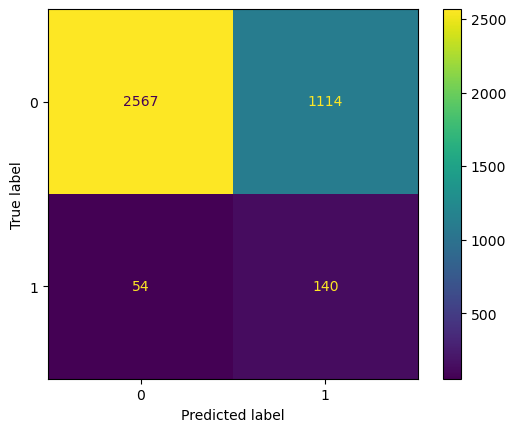

In [72]:
fig = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=grid_search_brf.classes_)
fig.plot()

In [73]:
print('accuracy = ',accuracy_score(y_test_rf, y_pred_rf))

accuracy =  0.6985806451612904


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


# Based on the Confusion Matrix, the results are not that impressive and hence dropping this approach
**SHAP is performed to see how the results align with Catboost**

In [ ]:
# y_pred_prob = grid_search_brf.best_estimator_.predict_proba(X_test.iloc[:,1:])
# y_pred = grid_search_brf.best_estimator_.predict(X_test.iloc[:,1:])

In [74]:
# save model
with open('brf_2_age_recall.pkl', 'wb') as f:
    pickle.dump(grid_search_brf.best_estimator_, f)

In [75]:
feat_imp = grid_search_brf.best_estimator_.feature_importances_

xgb_cols = X_train_rf.columns

In [76]:
feat_imp.shape

(45,)

In [77]:
xgb_cols = xgb_cols.drop('control_number')

In [78]:
feat_list = []
total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(xgb_cols, feat_imp):
    feat_list.append(feature)
    total_importance += feature[1]

In [79]:
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp['SUMMED_TOTAL'] = df_imp['IMPORTANCE'].cumsum()
df_imp.head(15)

,FEATURE,IMPORTANCE,SUMMED_TOTAL
44,donor_age_cal,0.185166,0.185166
6,median_home_value,0.073142,0.258308
7,median_household_income,0.059619,0.317927
8,pct_owner_occupied,0.054979,0.372906
11,recent_card_response_prop,0.049966,0.422872
16,months_since_first_gift,0.049513,0.472385
4,income_group,0.049251,0.521636
0,target_d25,0.046953,0.568589
15,months_since_last_gift,0.043240,0.611829
1,months_since_origin,0.041437,0.653266


In [347]:
df_imp

,FEATURE,IMPORTANCE,SUMMED_TOTAL
2,donor_age,0.328737,0.328737
6,median_home_value,0.061686,0.390423
7,median_household_income,0.048910,0.439333
16,months_since_first_gift,0.047751,0.487084
8,pct_owner_occupied,0.047613,0.534698
11,recent_card_response_prop,0.044797,0.579495
0,months_since_origin,0.040751,0.620246
4,income_group,0.040133,0.660378
15,months_since_last_gift,0.038128,0.698507
1,number_of_resp,0.035458,0.733964


In [64]:
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [80]:
model = grid_search_brf.best_estimator_
explainer = shap.TreeExplainer(model)

In [83]:
shap_values = explainer.shap_values(X_train_rf.drop(columns =['control_number']))

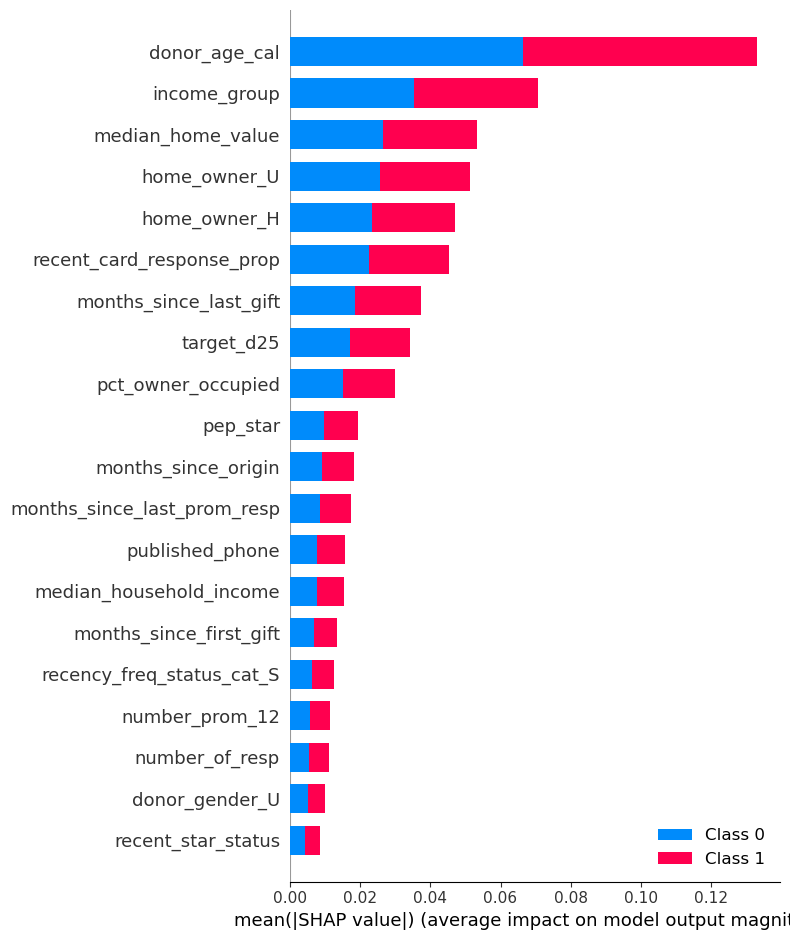

In [84]:
shap.summary_plot(shap_values, X_train_rf.drop(columns =['control_number']), plot_type="bar")


# Third Approach  (balancing data )

# SMOTE approach for imbalance data

In [1]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler

ModuleNotFoundError: No module named 'imblearn'

SMOTE + ENN:

SMOTE + ENN is another hybrid technique where more no. of observations are removed from the sample space. Here, ENN is yet another undersampling technique where the nearest neighbors of each of the majority class is estimated. If the nearest neighbors misclassify that particular instance of the majority class, then that instance gets deleted.

Integrating this technique with oversampled data done by SMOTE helps in doing extensive data cleaning. Here on misclassification by NN’s samples from both the classes are removed. This results in a more clear and concise class separation.

In [661]:
sm = SMOTEENN(random_state=0)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `

In [662]:
print('X_train: ',X_train.shape)
print('y_train: ',y_train.sum())
print('Ratio train: ',y_train.sum()/X_train.shape[0]*100,'%')
print('X_test: ',X_test.shape)
print('y_test: ',y_test.sum())
print('Ratio test: ',y_test.sum()/X_test.shape[0]*100,'%')
print('X_train_over: ',X_train_over.shape)
print('y_train_over: ',y_train_over.sum())
print('Ratio train_over: ',y_train_over.sum()/X_train_over.shape[0]*100,'%')

X_train:  (15497, 45)
y_train:  775
Ratio train:  5.000967929276634 %
X_test:  (3875, 45)
y_test:  194
Ratio test:  5.006451612903226 %
X_train_over:  (12491, 45)
y_train_over:  6888
Ratio train_over:  55.14370346649587 %


In [534]:
y_train_over.shape

(29444,)

In [535]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=0
)

In [536]:
parameters = {
#     'max_depth': range (2, 10, 1),
     'max_depth':  [5,7,10,13],
    'n_estimators': [200,250,300,350],
    'learning_rate': [0.1, 0.15,0.2],
    'scale_pos_weight' : [1,5,10, 15,20]

}
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
grid_search_over = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'f1',
    n_jobs = 10,
    cv = kfold,
    verbose=True
)


In [537]:
grid_search_over.fit(X_train_over.iloc[:,1:], y_train_over)
grid_search_over.best_estimator_






Fitting 10 folds for each of 240 candidates, totalling 2400 fits


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=350, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)

In [ ]:
print(grid_search_over.cv_results_)
print('\n Best estimator:')
print(grid_search_over.best_estimator_)

print('\n Best score:')
print(grid_search_over.best_score_ )
print('\n Best parameters:')
print(grid_search_over.best_params_)
results = pd.DataFrame(grid_search_over.cv_results_)
results.to_csv('xgb-grid-search-results-smote-04.csv', index=False)

In [539]:
y_pred_prob_over = grid_search_over.best_estimator_.predict_proba(X_test.iloc[:,1:])
y_pred_over = grid_search_over.best_estimator_.predict(X_test.iloc[:,1:])



is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


In [540]:
y_pred_over


array([0, 0, 0, ..., 0, 0, 0])

In [541]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred_over)
print(cm)
accuracy_score(y_test, y_pred_over)

[[3647   34]
 [ 181   13]]


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `

0.944516129032258

In [653]:
# save model
with open('xgb_smote_1.pkl', 'wb') as f:
    pickle.dump(grid_search_over.best_estimator_, f)

In [668]:
estimator = RandomForestClassifier(
    n_jobs = 4,
    random_state=0,
    criterion='gini'

)

parameters = {
    'max_depth': range (2, 15, 1),
    'n_estimators': range(100, 500, 50)
}

In [669]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search_rf_over = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'f1',
    n_jobs = 10,
    cv = kfold,
    verbose=True
)


grid_search_rf_over.fit(X_train_over.iloc[:,1:], y_train_over)
grid_search_rf_over.best_estimator_

Fitting 10 folds for each of 65 candidates, totalling 650 fits


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


RandomForestClassifier(max_depth=14, n_estimators=125, n_jobs=4, random_state=0)

In [ ]:
print(grid_search_rf_over.cv_results_)
print('\n Best estimator:')
print(grid_search_rf_over.best_estimator_)

print('\n Best score:')
print(grid_search_rf_over.best_score_ )
print('\n Best parameters:')
print(grid_search_rf_over.best_params_)
results = pd.DataFrame(grid_search_rf_over.cv_results_)
results.to_csv('rf-grid-search-results-smote-05.csv', index=False)

In [671]:
y_pred_prob_over_rf = grid_search_rf_over.best_estimator_.predict_proba(X_test.iloc[:,1:])
y_pred_over_rf = grid_search_rf_over.best_estimator_.predict(X_test.iloc[:,1:])


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


In [672]:

cm_over_rf = confusion_matrix(y_test, y_pred_over_rf)
print(cm_over_rf)
accuracy_score(y_test, y_pred_over_rf)

[[3551  130]
 [ 159   35]]


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `

0.9254193548387096

# The following are the other approaches tried for the results. They were not pursued further due to lack of good results in the initial attempts. Further trial may yield in better results but I have not pursued them

# Clustering approach

# Kmeans

In [405]:
df_id = df_categoried[['control_number','target_b']]

In [ ]:
X = df_categoried.drop(['control_number','target_b'],axis=1)

In [ ]:
X = X.values

In [ ]:
scaler_X = StandardScaler()

In [ ]:
X_scaled  = scaler_X.fit_transform(X)

In [ ]:
from sklearn.cluster import KMeans
wcss = []
for i in range(5, 20):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 47)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(5, 20), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

From above, Kmeans is not creating good set of clusters

In [ ]:
df_categoried2 = df_categoried.copy()

In [ ]:
drop2 = ['target_d6','target_d12','target_d18','target_d24'
#          ,
#        'cluster_code_new_cluster_code_0to10',
#          'cluster_code_new_cluster_code_11to20',
#          'cluster_code_new_cluster_code_21to30',
#         'cluster_code_new_cluster_code_31to40',
#          'cluster_code_new_cluster_code_41to50',
#          'cluster_code_new_cluster_code_51+',
#          'cluster_code_new_cluster_code_missing',
#          'donor_gender_A',
#           'donor_gender_F',
#           'donor_gender_M',
#           'donor_gender_U'
      
        ]

df_categoried2 = df_categoried2.drop(drop2,axis=1)

In [ ]:
df_categoried2.shape

In [ ]:
df_id = df_categoried[['control_number','target_b']]
X2 = df_categoried.drop(['control_number','target_b'],axis=1)
X2 = X2.values
scaler_X2 = StandardScaler()

min_max_scaler = MinMaxScaler()



X2_scaled  = scaler_X2.fit_transform(X2)

X2_norm  = min_max_scaler.fit_transform(X2)


from sklearn.cluster import KMeans
wcss = []
for i in range(20, 40):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 47)
    kmeans.fit(X2_scaled)
    #kmeans.fit(X2_norm)
    wcss.append(kmeans.inertia_)
plt.plot(range(20, 40), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
df_categoried2.drop('control_number',axis=1, inplace=True)

In [ ]:

kmeans = KMeans(n_clusters = 15, init = 'k-means++', random_state = 47)
kmeans.fit(X2_scaled)

#predictions from kmeans
pred = kmeans.predict(X2_scaled)


In [ ]:
frame = pd.DataFrame(scaler_X2.inverse_transform(X2_scaled))


In [ ]:
frame

In [ ]:
frame.columns = df_categoried2.columns
frame['cluster'] = pred

In [ ]:
frame['control_number'] = df_id2

In [ ]:
frame.cluster.value_counts()

In [ ]:
frame

In [ ]:
frame.groupby('cluster').agg({'target_b':'sum'})

# GMM approach

In [ ]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=10)
gmm.fit(X2_scaled)

#predictions from gmm
labels = gmm.predict(X2_scaled)

frame = pd.DataFrame(scaler_X2.inverse_transform(X2_scaled))
frame.columns = df_categoried2.columns
frame['cluster'] = labels
frame['control_number'] = df_id2
frame.cluster.value_counts()

In [ ]:
frame.groupby('cluster').agg({'target_b':'sum'})

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(5, 20),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(X2_scaled)

In [ ]:

df_gmm = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df_gmm["mean_test_score"] = -df_gmm["mean_test_score"]
df_gmm = df_gmm.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df_gmm.sort_values(by="BIC score").head()

In [ ]:
import seaborn as sns

sns.catplot(
    data=df_gmm,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

In [ ]:
df_gmm[df_gmm['BIC score'] == df_gmm['BIC score'].min() ]